In [3]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = ""
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec


from sklearn.metrics import roc_curve

from absl import app
from absl import flags

from datasets.data import load_dataset
import helpers
import utils.utils as u
import visualization as viz
from analyze_results_model import get_rejection_threshold

from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances

import config_flags

# Top

In [4]:
# FLAGS_FILE = "results/benchmark_osr/standard_vgg32/dist/cifar10/split-2/nb_f-5/anchor_mul-10/max_d-12.649/flags.txt"
# FLAGS_FILE = "results/tests_weight_loss/flags.txt"
# FLAGS_FILE = "results/crossentropy_features/30features_flags.txt"
# FLAGS_FILE = "results/tests_weight_loss/coef_2_3/coef_2_3_flags.txt"
# FLAGS_FILE = "results/tests/new_loss_belong/test_vgg32_new_1_flags.txt"
# FLAGS_FILE = "results/tests/new_loss_belong/linear/test_7/test_7_flags.txt"
# FLAGS_FILE = "results/tests/new_loss_belong/smaller_model/test_0/test_0_flags.txt"
# FLAGS_FILE = "results/tests/new_loss_belong/linear/test_9/test_9_flags.txt"
# FLAGS_FILE = "results/tests/new_loss_belong/linear/test_16/test_16_flags.txt"
# FLAGS_FILE = "results/tests/new_loss_belong/stl10/test_1/test_1_flags.txt"

In [5]:
# Flags for article results
# FLAGS_FILE = "results/benchmark_osr_v3/difair/tiny_imagenet/split_0/run_0_flags.txt"
# FLAGS_FILE = "results/tiny_imagenet/dr_0.5-lr_0.5/difair/tiny_imagenet/split_0/run_0_flags.txt"
# FLAGS_FILE = "results/tiny_imagenet/dr_0.5-lr_0.5/crossentropy/tiny_imagenet/split_0/run_0_flags.txt"
FLAGS_FILE = "results/benchmark_osr_v3/difair/cifar10/split_2/run_0_flags.txt"

In [6]:
config_flags.load_flags(FLAGS_FILE)
FLAGS = flags.FLAGS

In [7]:
w = "with" if FLAGS.data_augmentation else "without"
print(f"Model trained for {FLAGS.epochs} epochs {w} data augmentation on images of size {FLAGS.image_size}.")
print(f"Model: {FLAGS.model}")
print(f"Loss: {FLAGS.loss}")
print(f"Nb features: {FLAGS.nb_features}")
print(f"Anchor multiplier: {FLAGS.anchor_multiplier}")

Model trained for 600 epochs with data augmentation on images of size 64.
Model: standard_vgg32
Loss: crossentropy
Nb features: 0
Anchor multiplier: 10.0


In [8]:
# Load dataset
start_time = u.get_time()
datasets, nb_classes, nb_batches, nb_channels, norm_layer, classes_dict = load_dataset(
    FLAGS,
    shuffle=False,
    parallel_strategy=None,
    data_augmentation=False
)
print("--- Data preprocessing time : %s ---" % (u.exec_time(start_time)))
print(classes_dict)

class_anchors = tf.repeat(tf.eye(nb_classes), FLAGS.nb_features, axis=1)
class_anchors *= FLAGS.anchor_multiplier

# Load model    
print(FLAGS.save_path, FLAGS.prefix)
MODEL_PATH = os.path.join(FLAGS.save_path, FLAGS.prefix) + "model.save"
model = tf.keras.models.load_model(MODEL_PATH)
model.summary()

Dataset: tiny_imagenet
Known classes: [108, 147, 17, 58, 193, 123, 72, 144, 75, 167, 134, 14, 81, 171, 44, 197, 152, 66, 1, 133]
Unknown classes: [0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 15, 16, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 59, 60, 61, 62, 63, 64, 65, 67, 68, 69, 70, 71, 73, 74, 76, 77, 78, 79, 80, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 124, 125, 126, 127, 128, 129, 130, 131, 132, 135, 136, 137, 138, 139, 140, 141, 142, 143, 145, 146, 148, 149, 150, 151, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 168, 169, 170, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 194, 195, 196, 198, 199]
nb_train_examples: 10000
mean: [0.47541523, 0.4470269

In [9]:
# Model performances
with open(os.path.join(FLAGS.save_path, FLAGS.prefix) + "history.pkl", "rb") as f:
    history = pd.read_pickle(f)

print("Accuracy on test set:", history["test_accuracy"][-1]*100)
print("Loss on test set:", history["test_loss"][-1])
print("Real AUROC on test set:", history["test_real_auroc"][-1])
print("Max val AUROC on test set:", history["test_max_val_auroc"][-1])

Accuracy on test set: 78.1000018119812
Loss on test set: 0.8510276
Real AUROC on test set: 77.11749999999999
Max val AUROC on test set: 77.11749999999999


In [10]:
loss_helper = helpers.get_loss_helper(FLAGS, class_anchors, nb_classes)

Training with loss: crossentropy


In [11]:
ANALYZE = "representation"
# ANALYZE = "output"

# Define feature extraction
if ANALYZE == "representation":
    print("Looking at representation of the model")
    get_features = tf.keras.models.Model(
        inputs=model.inputs,
        # outputs=model.get_layer(name="global_average_pooling2d").output,
        outputs=model.get_layer(name="features_layer").output,
    )
elif ANALYZE == "output":
    print("Looking at output of the model")
    get_features = model
else:
    raise ValueError(f"Unknown value for 'analyse': {ANALYZE}")

Looking at representation of the model


In [12]:
#####################
# Get images, labels and features for known and unknown images from test set
known_images, known_labels = zip(*datasets["ds_test_known"].unbatch())
known_images = np.array(known_images)
known_labels = np.array(known_labels)
label_names = [classes_dict[i] for i in range(nb_classes)]

known_features = get_features.predict(known_images)
known_pred_raw = model.predict(known_images)
known_pred_raw_label = loss_helper.predicted_class(known_pred_raw)


unknown_images, raw_unknown_labels = zip(*datasets["ds_test_unknown"].unbatch())
unknown_images = np.array(unknown_images)
raw_unknown_labels = np.array(raw_unknown_labels)

unknown_features = get_features.predict(unknown_images)
unknown_labels = np.array([-label-1 for label in raw_unknown_labels]) # negated-1 labels for unknowns
unknown_pred_raw = model.predict(datasets["ds_test_unknown"])
unknown_pred_raw_label = loss_helper.predicted_class(unknown_pred_raw)
#####################

8/8 [==============================] - 2s 192ms/step


In [13]:
uniques, counts = np.unique(known_labels, return_counts=True)
uniques_uk, counts_uk = np.unique(unknown_labels, return_counts=True)
print("Known labels:", len(uniques), np.sum(counts), counts)
print("Unknown labels:", len(uniques_uk), np.sum(counts_uk), counts_uk)

Known labels: 20 1000 [50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50]
Unknown labels: 180 1000 [ 5  8  4  4  2 10  8  1  9  5  6  5 12 11  4  5  7  4  6  7  8  4  6  5
  5  5  5  9  6  5  3  5  6  4  1  6  4  8  7  6  7 10  4  3  3  4 10  7
  1  6  9  3  6  4  6  4  6  7  6  5  8  1  4  8  2  5  8  4  6  4  6  4
  5  8  5  5  4  5  5  7  5  4  9  7  3  7  9  6  2  5  5  2  4  3  2  4
  5  7  5  6  7  9  3  4  8  4  5  6  6  5  4  2  6  4  6  7  9  8  7  3
  6  3  6  5  8 10  5  6  2  8  6  3  4  7  7  6  4  6  4  7  7  6  8  8
  5  3  4  8  7  2  4  6  6  6  2  8  3  3  6  2  3  8  8  9 10  4  7  4
  6  5  5  5  6  7  9  8  5  6  3  6]


In [14]:
print(-uniques_uk-1)

[199 198 196 195 194 192 191 190 189 188 187 186 185 184 183 182 181 180
 179 178 177 176 175 174 173 172 170 169 168 166 165 164 163 162 161 160
 159 158 157 156 155 154 153 151 150 149 148 146 145 143 142 141 140 139
 138 137 136 135 132 131 130 129 128 127 126 125 124 122 121 120 119 118
 117 116 115 114 113 112 111 110 109 107 106 105 104 103 102 101 100  99
  98  97  96  95  94  93  92  91  90  89  88  87  86  85  84  83  82  80
  79  78  77  76  74  73  71  70  69  68  67  65  64  63  62  61  60  59
  57  56  55  54  53  52  51  50  49  48  47  46  45  43  42  41  40  39
  38  37  36  35  34  33  32  31  30  29  28  27  26  25  24  23  22  21
  20  19  18  16  15  13  12  11  10   9   8   7   6   5   4   3   2   0]


In [15]:
mean_features = np.zeros((nb_classes, known_features.shape[1]))
for i in range(nb_classes):
    mean_features[i] = np.mean(known_features[known_labels == i], axis=0)

In [16]:
ACTUALIZE_CENTERS = False

train_images, train_labels = zip(*datasets["ds_train_known"].unbatch())
train_images = np.array(train_images)
train_labels = np.array(train_labels)

# Compute new class centers if needed
if ACTUALIZE_CENTERS :    
    # need to unbatch everything cause otherwise dataset isn't going to be
    # seen deterministically
    
    mean_centers = u.actualize_centers(model, get_features, train_images, train_labels,
                                        loss_helper, nb_classes, FLAGS.batch_size)
else:
    mean_centers = class_anchors

In [17]:
import pickle as pkl
save_dir = 'results/analysis_data/'
# pkl.dump(mean_centers, open(save_dir + 'mean_features_difair.pkl', 'wb'))

In [18]:
classes_dict

{0: 'jinrikisha, ricksha, rickshaw',
 1: 'beach wagon, station wagon, wagon, estate car, beach waggon, station waggon, waggon',
 2: 'guinea pig, Cavia cobaya',
 3: 'pay-phone, pay-station',
 4: 'gondola',
 5: 'Christmas stocking',
 6: 'birdhouse',
 7: 'teddy, teddy bear',
 8: 'tractor',
 9: 'mashed potato',
 10: 'apron',
 11: 'brown bear, bruin, Ursus arctos',
 12: 'neck brace',
 13: 'chain',
 14: 'lesser panda, red panda, panda, bear cat, cat bear, Ailurus fulgens',
 15: 'binoculars, field glasses, opera glasses',
 16: 'trolleybus, trolley coach, trackless trolley',
 17: 'tabby, tabby cat',
 18: 'reel',
 19: 'barn',
 -1: 'Egyptian cat',
 -3: 'volleyball',
 -4: 'rocking chair, rocker',
 -5: 'lemon',
 -6: 'bullfrog, Rana catesbeiana',
 -7: 'basketball',
 -8: 'cliff, drop, drop-off',
 -9: 'espresso',
 -10: "plunger, plumber's helper",
 -11: 'parking meter',
 -12: 'German shepherd, German shepherd dog, German police dog, alsatian',
 -13: 'dining table, board',
 -14: 'monarch, monarch butt

In [19]:
# mean_centers_difar = pkl.load(open(save_dir + 'mean_features_difair.pkl', 'rb'))

# fig, axs = plt.subplots(1, 2, figsize=(11, 4))

# # ACTUALIZE_CENTERS needs to be True if the model was trained with crossentropy
# im1 = axs[0].imshow(mean_centers[3].reshape(-1, FLAGS.nb_features), cmap="OrRd")
# axs[0].set_title("Cross entropy", fontsize=16)
# axs[0].set_xticks(range(FLAGS.nb_features), range(FLAGS.nb_features))
# plt.colorbar(im1, ax=axs[0])

# im2 = axs[1].imshow(mean_centers_difar[3].reshape(-1, FLAGS.nb_features), cmap="OrRd")
# axs[1].set_yticks(range(nb_classes), label_names, fontsize=14)
# axs[1].set_xticks(range(FLAGS.nb_features), range(FLAGS.nb_features))
# axs[1].set_title("DIFAIR", fontsize=16)
# # for i in range(nb_classes):
# #     for j in range(FLAGS.nb_features):
# #         axs[1].text(j, i, f"{mean_centers_difar[3][i*FLAGS.nb_features+j]:.2f}", ha="center", va="center", color="b")
# plt.colorbar(im2, ax=axs[1])

# plt.savefig('results/analysis_data/cat_repr_comparison.pdf', dpi=300, bbox_inches='tight')
# plt.show()


In [20]:
SUM_REPRESENTATION_MAGNITUDE = False

# Override osr_score method with max 'output' score if needed
if SUM_REPRESENTATION_MAGNITUDE:
    def osr_score(y_pred, class_anchors=None):
        reshaped = tf.reshape(y_pred, (-1, nb_classes, FLAGS.nb_features))
        return tf.reduce_sum(tf.norm(reshaped, axis=1), axis=1)  
    
    def predicted_class(pred, class_anchors=None, threshold=None):      
        pred = pred.reshape(-1, nb_classes, FLAGS.nb_features)
        preds = tf.reduce_max(pred, axis=2)
        preds = tf.argmax(preds, axis=1)
        return preds

    roc_score_helper = helpers.get_loss_helper(FLAGS, mean_centers, nb_classes)
    roc_score_helper.osr_score = osr_score # override osr_score method
    roc_score_helper.predicted_class = predicted_class # override predicted_class method
    roc_score_helper.score_type = "min"
else:
    roc_score_helper = loss_helper

In [21]:
# MAX_OUTPUT_SCORE = False

# # Override osr_score method with max 'output' score if needed
# if MAX_OUTPUT_SCORE:
#     def osr_score(y_pred, class_anchors=None):
#         return tf.reduce_max(y_pred, axis=1)    
    
#     def predicted_class(pred, class_anchors=None, threshold=None):      
#         pred = pred.reshape(-1, nb_classes, FLAGS.nb_features)
#         preds = tf.reduce_max(pred, axis=2)
#         preds = tf.argmax(preds, axis=1)
#         return preds

#     roc_score_helper = helpers.get_loss_helper(FLAGS, mean_centers, nb_classes)
#     roc_score_helper.osr_score = osr_score # override osr_score method
#     roc_score_helper.predicted_class = predicted_class # override predicted_class method
#     roc_score_helper.score_type = "max"
# else:
#     roc_score_helper = loss_helper

In [22]:
roc_score_helper

ROC AUC score: 0.771


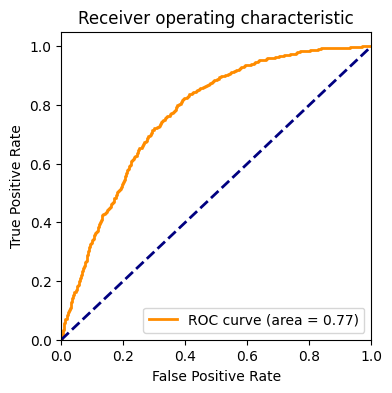

In [23]:
from sklearn.metrics import roc_curve, auc
score_known = roc_score_helper.osr_score(known_pred_raw)
score_unknown = roc_score_helper.osr_score(unknown_pred_raw)
y_true, y_pred = roc_score_helper._format_score(score_known, score_unknown)


fpr, tpr, _ = roc_curve(y_true, y_pred)
roc_auc = auc(fpr, tpr)
print(f"ROC AUC score: {roc_auc:.3f}")

plt.figure(figsize=(4, 4))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

In [24]:
rejection_threshold = get_rejection_threshold(known_pred_raw, unknown_pred_raw, roc_score_helper)
print("Rejection threshold:", rejection_threshold)
print("Hypersphere radius:", FLAGS.max_dist)

For a TPR of 0.9, FPR is 0.523 (i.e. 52.30% of knowns are classified as unknowns)
Threshold: 12.664917
Rejection threshold: 12.664917
Hypersphere radius: 18.974


In [25]:
known_pred_thr_label = roc_score_helper.predict_w_threshold(known_pred_raw, 
                                                 threshold=rejection_threshold, 
                                                 type=roc_score_helper.score_type)
rejected_k_preds = known_pred_thr_label == -1
accepted_k_preds = ~rejected_k_preds

unknown_pred_thr_label = roc_score_helper.predict_w_threshold(unknown_pred_raw, 
                                                threshold=rejection_threshold, 
                                                type=roc_score_helper.score_type)
rejected_uk_preds = unknown_pred_thr_label == -1
accepted_uk_preds = ~rejected_uk_preds

In [26]:
#( DEBUG ckeck tpr / fpr scores
r = np.unique(known_pred_thr_label, return_counts=True)
print("Knowns:", r[0], r[1]/len(known_pred_thr_label))

r = np.unique(unknown_pred_thr_label, return_counts=True)
print("Unknowns:", r[0], r[1]/len(unknown_pred_thr_label))
#)

Knowns: [-1  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19] [0.523 0.028 0.027 0.019 0.018 0.028 0.032 0.015 0.022 0.024 0.031 0.031
 0.032 0.023 0.01  0.029 0.018 0.035 0.027 0.008 0.02 ]
Unknowns: [-1  0  1  2  3  4  5  7  9 10 11 12 13 14 15 16 17 18 19] [0.9   0.001 0.008 0.001 0.007 0.002 0.006 0.002 0.023 0.008 0.007 0.012
 0.005 0.001 0.005 0.004 0.004 0.003 0.001]


# Outputs of anything

In [25]:
# # To save crossentropy visualizations
#     fig1, (ax1, ax2) = plt.subplots(1, 2, figsize=(5, 4))
#     vmin_ce = np.min([np.min(reshaped), np.min(mean_features[predicted_class])])
#     vmax_ce = np.max([np.max(reshaped), np.max(mean_features[predicted_class])])

#     im = ax1.imshow(reshaped, cmap="OrRd", vmin=vmin_ce, vmax=vmax_ce)
#     ax1.set_title(f"{class_name}\nrepresentation", fontsize=12)
    
#     im = ax2.imshow(mean_features[predicted_class].reshape(new_shape), cmap="OrRd", vmin=vmin_ce, vmax=vmax_ce)
#     ax2.set_title(f"Mean representation\nof {classes_dict[predicted_class].split(',')[0]}", fontsize=12)
#     # add space for color bar
#     fig1.subplots_adjust(right=0.8, top=0.8)
#     cbar_ax = fig1.add_axes([0.85, 0.1, 0.03, 0.7])
#     fig1.colorbar(im, cax=cbar_ax)
    
#     fig1.suptitle("Cross-entropy", fontsize=16)
#     if save_name is not None:
#         fig1.savefig(
#             f"{save_name}_representation_{class_name}_{class_id}_{index}.pdf",
#             dpi=300, bbox_inches="tight")

In [26]:
def model_outputs(class_name, index=0, top=6, save_name=None):
    save_path = os.path.join(
        FLAGS.save_path, FLAGS.prefix + class_name + "_" + str(index) + "_repr.pdf"
    )

    inverse_dict = {v.rsplit(",")[0]: k for k, v in classes_dict.items()}
    class_id = inverse_dict[class_name]
    known_classes = [classes_dict[i].rsplit(",")[0] for i in range(nb_classes)]

    fig = plt.figure(figsize=(14, 4))
    gs = GridSpec(1, 3, figure=fig, width_ratios=[1, 3, 3])
    axs = [
        fig.add_subplot(gs[0, 0]),
        fig.add_subplot(gs[0, 1]),
        fig.add_subplot(gs[0, 2]),
    ]

    if class_id < 0:
        images = unknown_images
        features = unknown_features
        outputs = unknown_pred_raw
        labels = unknown_labels
    else:
        images = known_images
        features = known_features
        outputs = known_pred_raw
        labels = known_labels

    class_features = features[labels == class_id]
    class_outputs = outputs[labels == class_id]

    print("OSR score:", roc_score_helper.osr_score([class_outputs[index]]).numpy()[0])

    predicted_class = loss_helper.predicted_class([class_outputs[index]]).numpy()[0]
    print(predicted_class)
    print(f"Predicted class: {classes_dict[predicted_class].split(',')[0]}")

    predicted_class_w_thr = roc_score_helper.predict_w_threshold(
        np.array([class_outputs[index]]),
        rejection_threshold,
        roc_score_helper.score_type,
    ).numpy()[0]
    predicted_name = (
        classes_dict[predicted_class_w_thr].split(',')[0] if predicted_class_w_thr >= 0 else "unknown"
    )
    print(f"Predicted class with rejection threshold: {predicted_name}")

    # Plotting

    # AX[0] : Image
    axs[0].imshow(images[labels == class_id][index] / 255)
    axs[0].set_title(
        f"True class: {class_name}\nPredicted class: {classes_dict[predicted_class].split(',')[0]}",
        fontsize=16,
    )
    axs[0].axis("off")

    if save_name is not None:
        plt.figure(figsize=(4, 4))
        plt.imshow(images[labels == class_id][index] / 255)
        plt.axis("off")
        plt.savefig(
            save_name.rsplit("/", 1)[0] + f"/{class_name}_{index}_img.pdf",
            dpi=300,
            bbox_inches="tight",
        )

    # AX[1] : Features
    if ANALYZE == "representation":
        new_shape = (-1, FLAGS.nb_features)
    else:
        new_shape = (nb_classes, 1)
    # new_shape = (16, 8)

    vmin = np.min(
        [np.min(class_features[index]), np.min(mean_features[predicted_class])]
    )
    vmax = np.max(
        [np.max(class_features[index]), np.max(mean_features[predicted_class])]
    )

    reshaped = output = class_features[index].reshape(new_shape)

    # get top k
    top_k = np.argsort(np.sum(reshaped, axis=1))[-top:][::-1]
    # top_k = range(16)
    reshaped = reshaped[top_k]

    im = axs[1].imshow(reshaped, cmap="OrRd", vmin=vmin, vmax=vmax)
    axs[1].set_title("Features", fontsize=16)
    if FLAGS.loss == "difair":
        axs[1].set_yticks(range(top), np.array(known_classes)[top_k])
    for i in range(top):
        for j in range(new_shape[1]):
            axs[1].text(
                j, i, f"{reshaped[i, j]:.2f}", ha="center", va="center", color="k"
            )

    # Representation to save
    fig, ax = plt.subplots(1, 1, figsize=(5, 4))
    im = ax.imshow(reshaped, cmap="OrRd", vmin=0, vmax=10)
    ax.set_title("DIFAIR", fontsize=16)
    if FLAGS.loss == "difair":
        ax.set_yticks(range(top), np.array(known_classes)[top_k], fontsize=12)
    for i in range(top):
        for j in range(new_shape[1]):
            ax.text(
                j,
                i,
                f"{reshaped[i, j]:.2f}",
                ha="center",
                va="center",
                color="k",
                fontsize=12,
            )
    plt.colorbar(im, shrink=0.7, ax=ax)
    if save_name is not None:
        fig.savefig(
            f"{save_name}_representation_{class_name}_{class_id}_{index}.pdf",
            dpi=300, bbox_inches="tight")

    # AX[2] : Mean representation of predicted class
    reshaped = mean_features[predicted_class].reshape(new_shape)

    # get top k
    reshaped = reshaped[top_k]

    im = axs[2].imshow(reshaped, cmap="OrRd", vmin=vmin, vmax=vmax)
    axs[2].set_title("Mean representation of\npredicted class", fontsize=16)
    if FLAGS.loss == "difair":
        axs[2].set_yticks(range(top), np.array(known_classes)[top_k])
    for i in range(top):
        for j in range(new_shape[1]):
            axs[2].text(
                j, i, f"{reshaped[i, j]:.2f}", ha="center", va="center", color="k"
            )

    fig.tight_layout()
    plt.colorbar(im, shrink=0.7, ax=axs[1:])
    plt.savefig(save_path, dpi=300, bbox_inches="tight")

    plt.show()

    return output

In [27]:
classes_dict

{0: 'jinrikisha, ricksha, rickshaw',
 1: 'beach wagon, station wagon, wagon, estate car, beach waggon, station waggon, waggon',
 2: 'guinea pig, Cavia cobaya',
 3: 'pay-phone, pay-station',
 4: 'gondola',
 5: 'Christmas stocking',
 6: 'birdhouse',
 7: 'teddy, teddy bear',
 8: 'tractor',
 9: 'mashed potato',
 10: 'apron',
 11: 'brown bear, bruin, Ursus arctos',
 12: 'neck brace',
 13: 'chain',
 14: 'lesser panda, red panda, panda, bear cat, cat bear, Ailurus fulgens',
 15: 'binoculars, field glasses, opera glasses',
 16: 'trolleybus, trolley coach, trackless trolley',
 17: 'tabby, tabby cat',
 18: 'reel',
 19: 'barn',
 -1: 'Egyptian cat',
 -3: 'volleyball',
 -4: 'rocking chair, rocker',
 -5: 'lemon',
 -6: 'bullfrog, Rana catesbeiana',
 -7: 'basketball',
 -8: 'cliff, drop, drop-off',
 -9: 'espresso',
 -10: "plunger, plumber's helper",
 -11: 'parking meter',
 -12: 'German shepherd, German shepherd dog, German police dog, alsatian',
 -13: 'dining table, board',
 -14: 'monarch, monarch butt

In [28]:
np.linalg.norm([2.17, -3.09, 0.85, 0.97, 4.37])

5.917541719329066

In [29]:
mean_repr = np.array([5]*5+[0.1]*95)
anchor = np.array([10]*5+[0]*95)
np.linalg.norm(mean_repr - anchor)

11.222744762311939

OSR score: 8.711377
6
Predicted class: birdhouse
Predicted class with rejection threshold: birdhouse


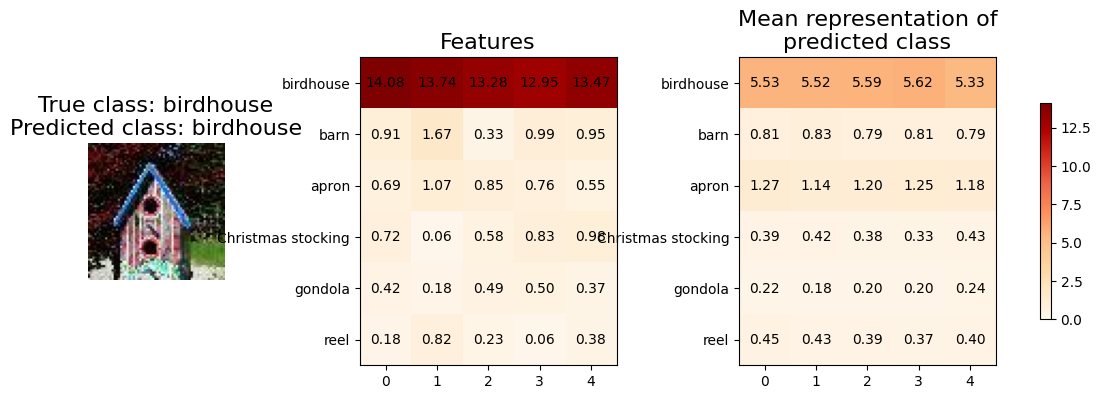

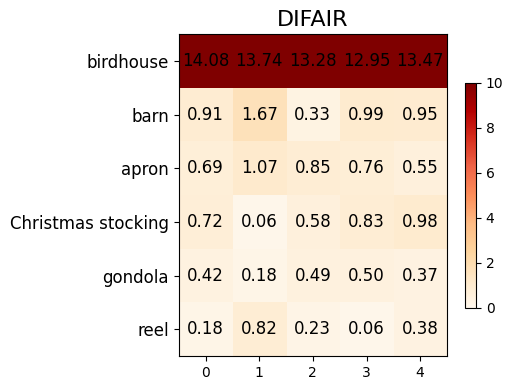

In [36]:
repr = model_outputs(
    "birdhouse",
    index=0,
    # save_name="results/figures/image_vision_computing/difair_tinyim",
)

In [307]:
np.sum(np.linalg.norm(repr, axis=1))

13.941777

0
OSR score: 12.002434
17
Predicted class: tabby, tabby cat
Predicted class with rejection threshold: unknown


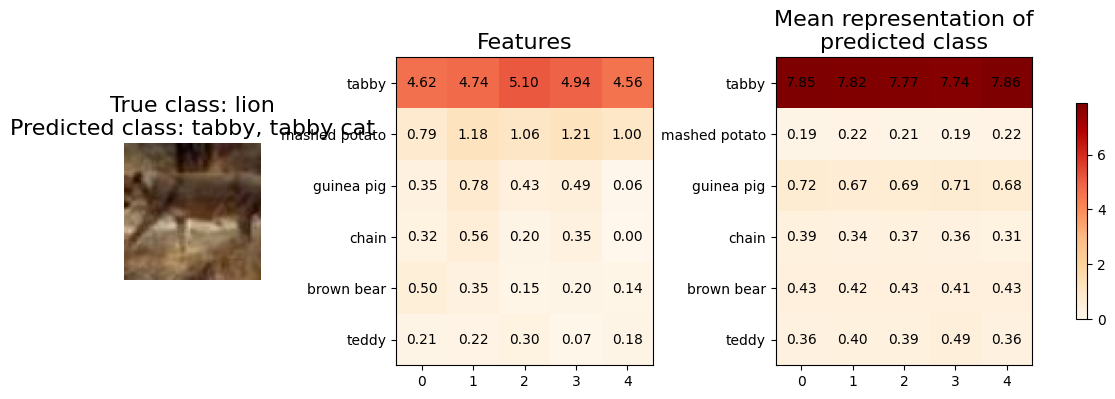

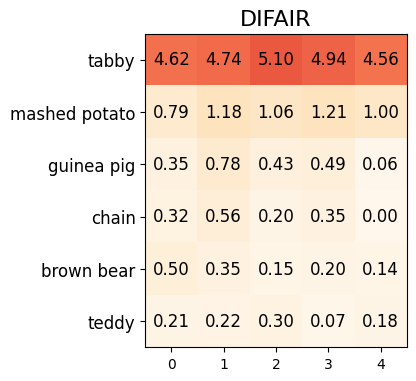

--------------------------------------------------
1
OSR score: 17.98855
11
Predicted class: brown bear, bruin, Ursus arctos
Predicted class with rejection threshold: unknown


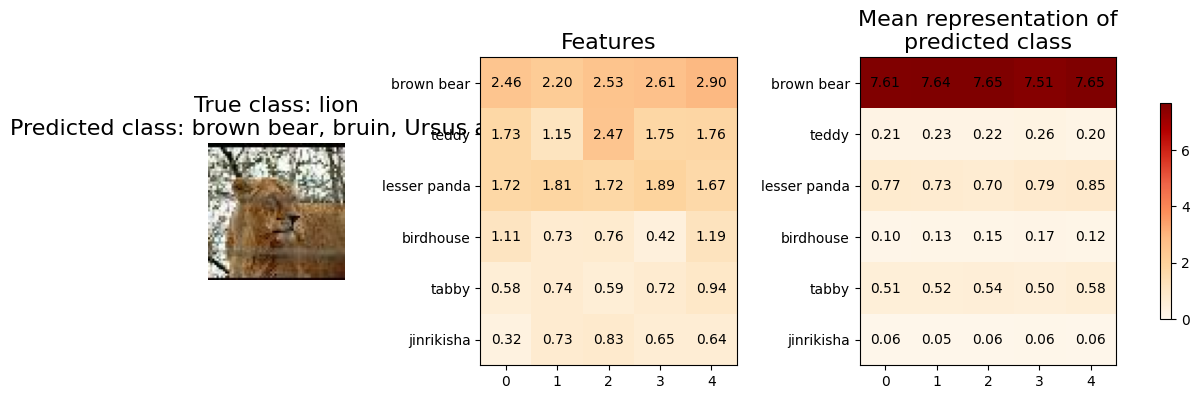

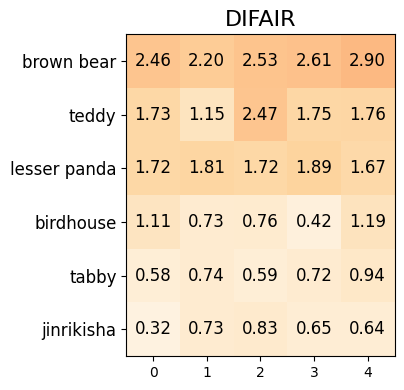

--------------------------------------------------
2
OSR score: 12.243662
17
Predicted class: tabby, tabby cat
Predicted class with rejection threshold: unknown


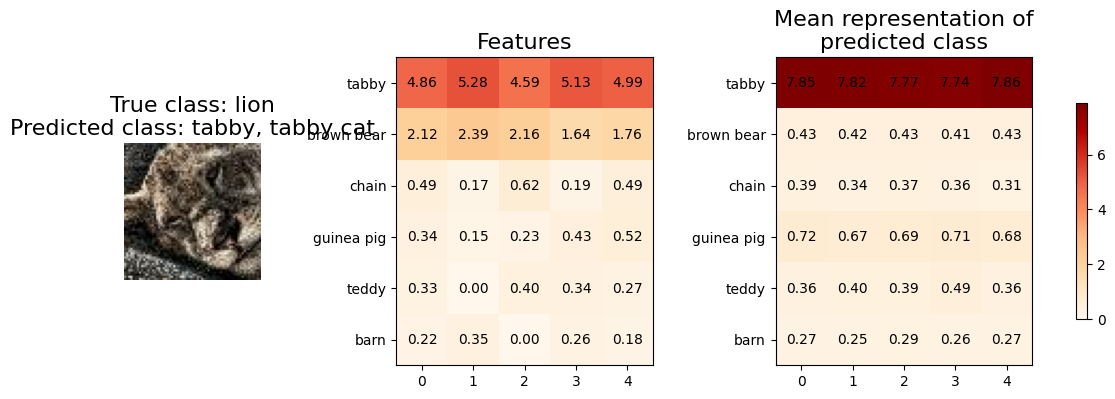

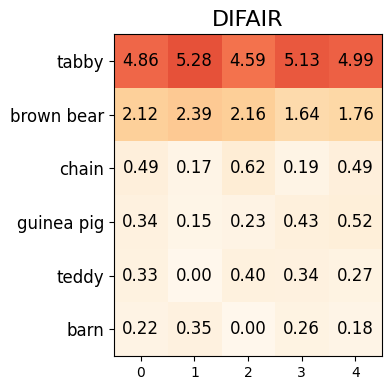

--------------------------------------------------
3
OSR score: 15.848955
17
Predicted class: tabby, tabby cat
Predicted class with rejection threshold: unknown


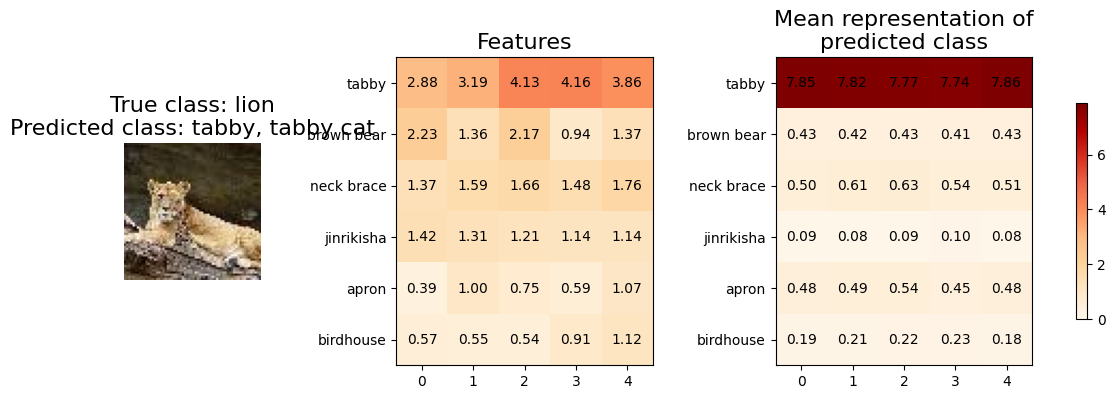

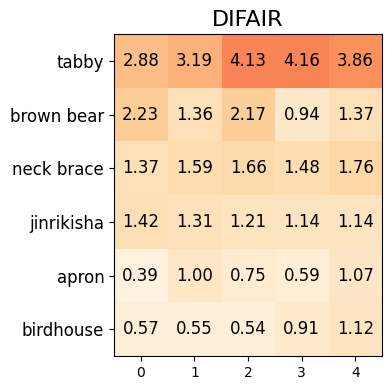

--------------------------------------------------
4
OSR score: 15.095361
2
Predicted class: guinea pig, Cavia cobaya
Predicted class with rejection threshold: unknown


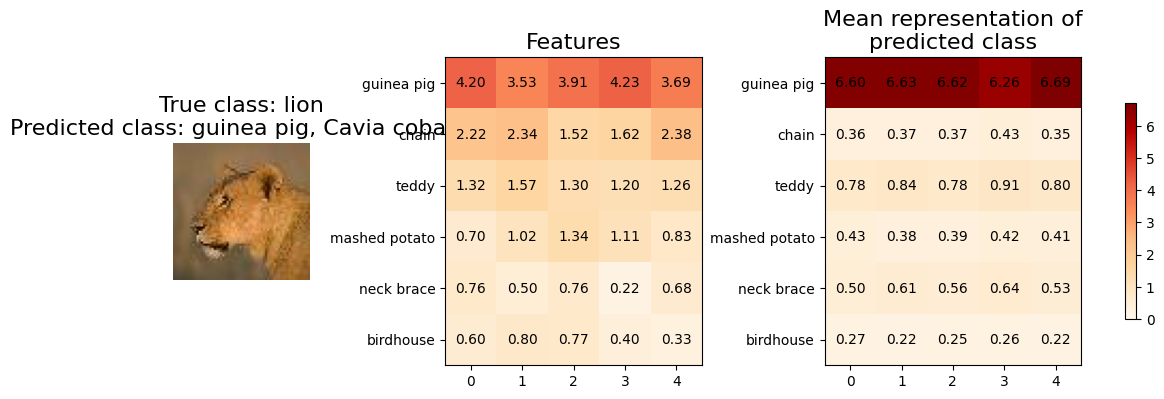

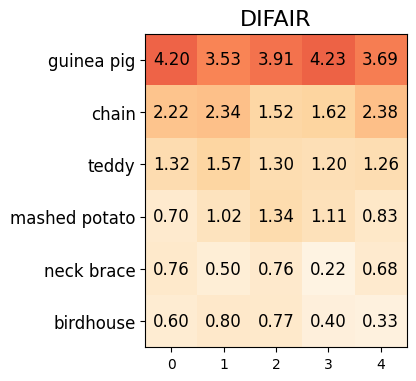

--------------------------------------------------
5
OSR score: 9.184645
11
Predicted class: brown bear, bruin, Ursus arctos
Predicted class with rejection threshold: brown bear, bruin, Ursus arctos


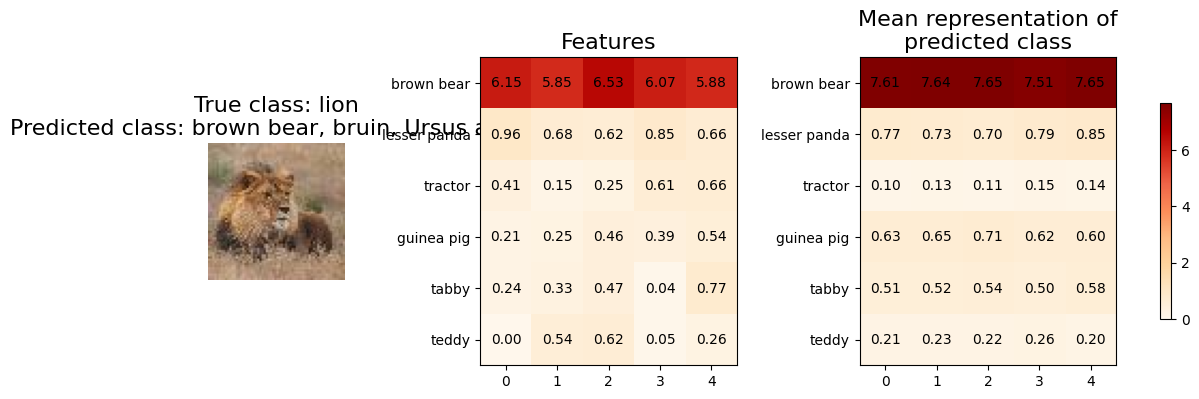

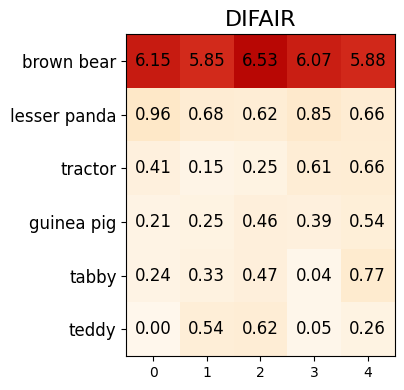

--------------------------------------------------
6
OSR score: 10.614755
11
Predicted class: brown bear, bruin, Ursus arctos
Predicted class with rejection threshold: unknown


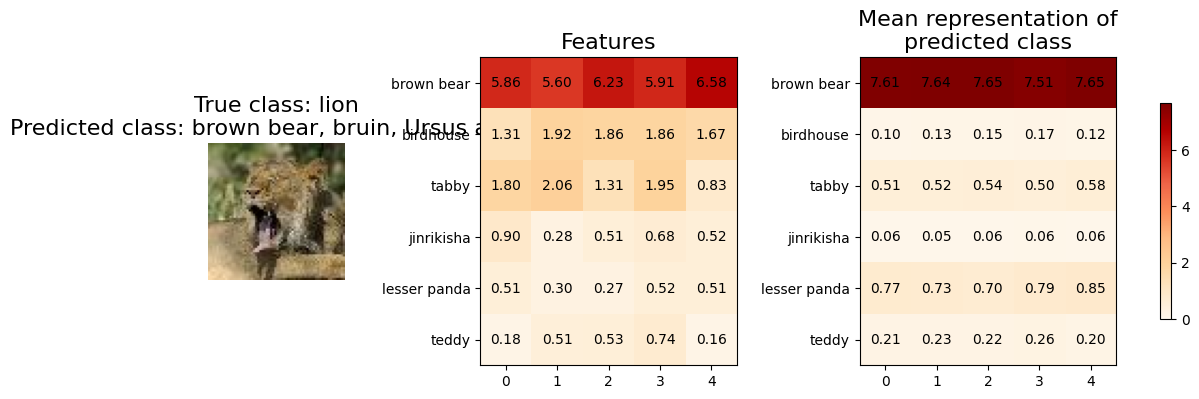

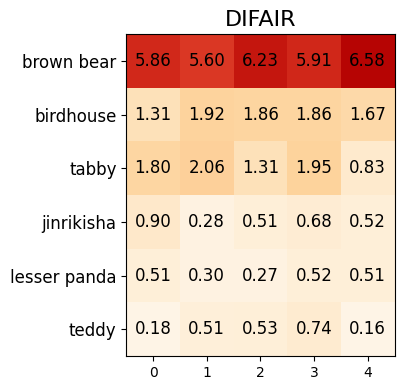

--------------------------------------------------
7
OSR score: 12.271463
17
Predicted class: tabby, tabby cat
Predicted class with rejection threshold: unknown


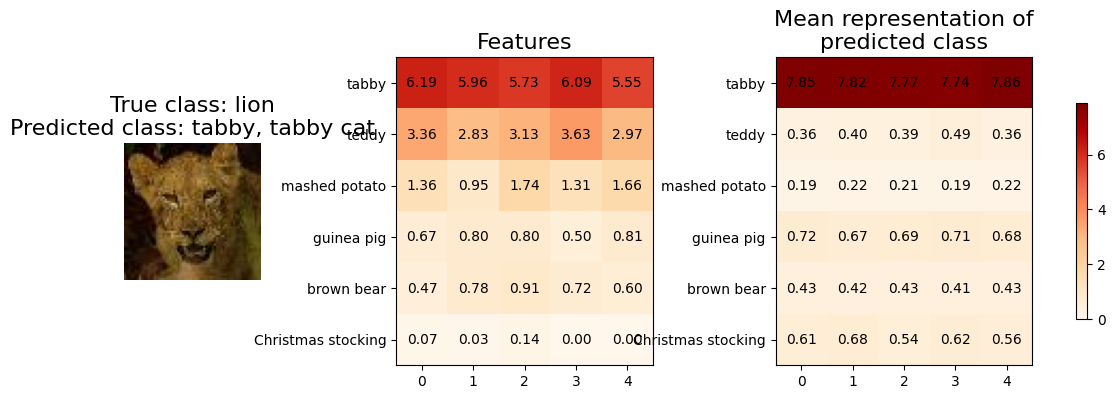

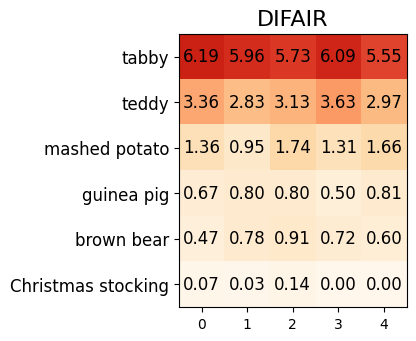

--------------------------------------------------
8
OSR score: 17.45987
11
Predicted class: brown bear, bruin, Ursus arctos
Predicted class with rejection threshold: unknown


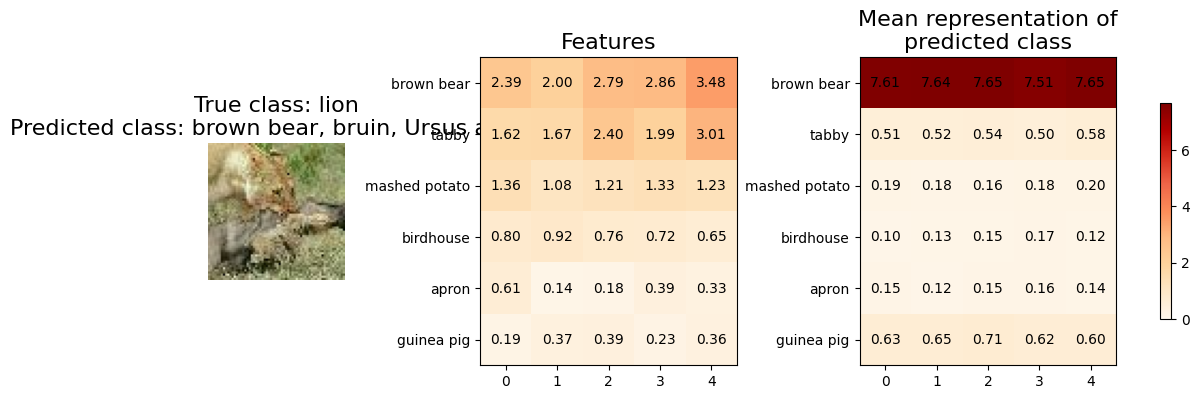

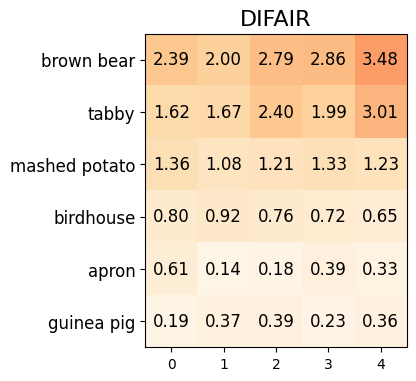

--------------------------------------------------
9
OSR score: 16.86291
17
Predicted class: tabby, tabby cat
Predicted class with rejection threshold: unknown


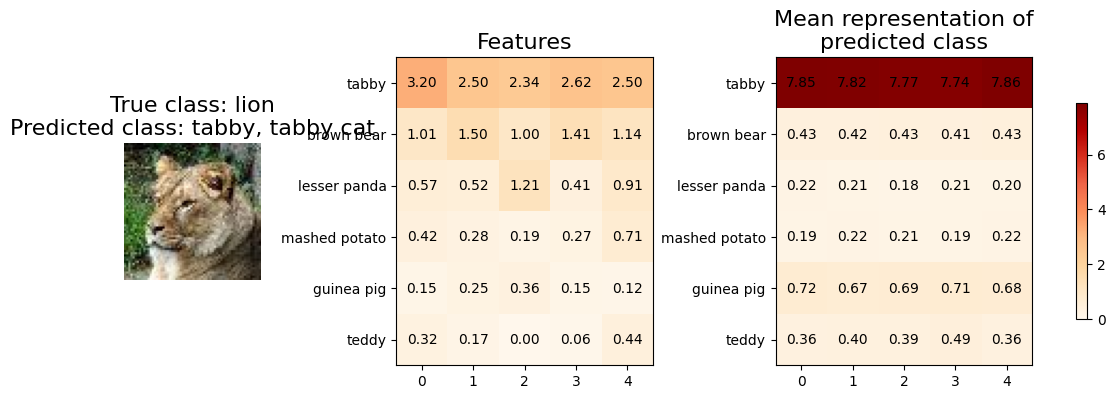

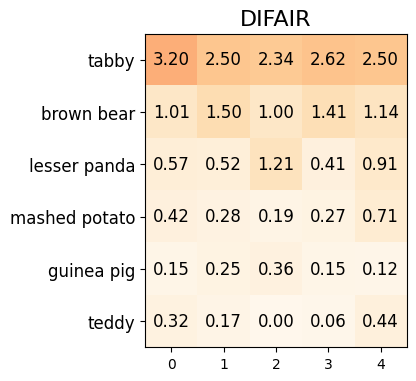

--------------------------------------------------
10
OSR score: 11.103358
11
Predicted class: brown bear, bruin, Ursus arctos
Predicted class with rejection threshold: unknown


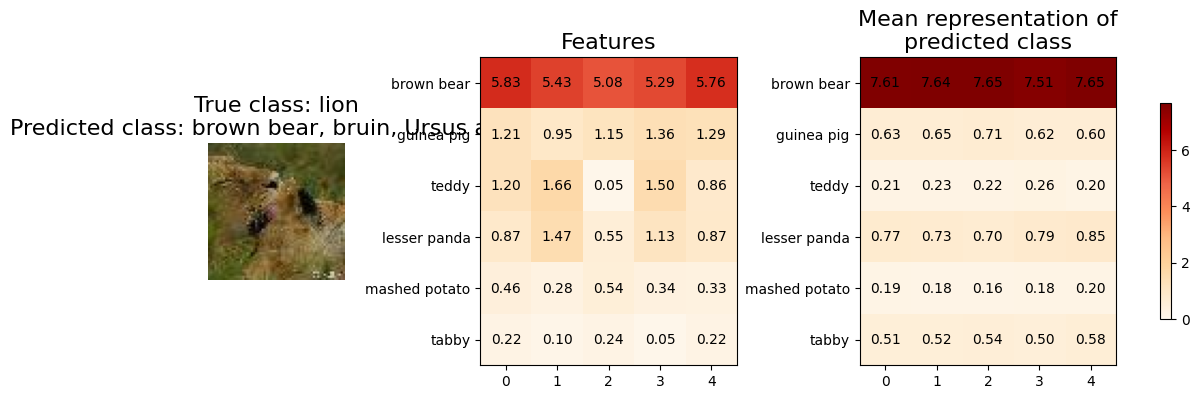

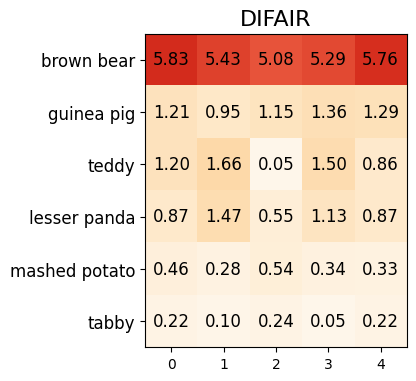

--------------------------------------------------
11


IndexError: index 11 is out of bounds for axis 0 with size 11

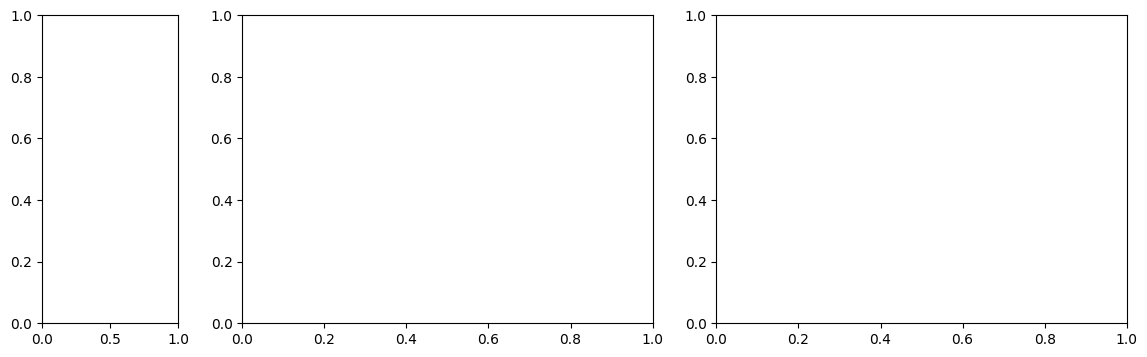

In [84]:
for i in range(50):
    print(i)
    repr = model_outputs("lion", index=i)
    print("-"*50)

# Rejected (known or unknown)

In [125]:
def rejected_outputs(class_name, index=0, top=6):
    save_path=os.path.join(FLAGS.save_path, 
                           FLAGS.prefix + class_name + "_" + str(index) + "_ro_repr.pdf")
    
    inverse_dict = {v: k for k, v in classes_dict.items()}
    class_id = inverse_dict[class_name]
    known_classes = [classes_dict[i].rsplit(',')[0] for i in range(nb_classes)]
    
    fig = plt.figure(figsize=(9, 4))
    gs = GridSpec(1, 2, figure=fig, width_ratios=[1, 3])
    axs = [fig.add_subplot(gs[0, 0]), fig.add_subplot(gs[0, 1])]
    
    if class_id < 0:
        images = unknown_images[rejected_uk_preds]
        features = unknown_features[rejected_uk_preds]
        outputs = unknown_pred_raw[rejected_uk_preds]
        labels = unknown_labels[rejected_uk_preds]
    else:
        images = known_images[rejected_k_preds]
        features = known_features[rejected_k_preds]
        outputs = known_pred_raw[rejected_k_preds]
        labels = known_labels[rejected_k_preds]
        
    class_features = features[labels == class_id]
    class_outputs = outputs[labels == class_id]
    
    print("OSR score:", roc_score_helper.osr_score([class_outputs[index]]).numpy()[0])
    
    axs[0].imshow(images[labels == class_id][index]/255)
    axs[0].axis("off")
    
    if ANALYZE == "representation":
        new_shape = (-1, FLAGS.nb_features)
    else:
        new_shape = (nb_classes, 1) 
    
    reshaped = class_features[index].reshape(new_shape)

    # get top k
    top_k = np.argsort(np.sum(reshaped, axis=1))[-top:]
    reshaped = reshaped[top_k]

    im = axs[1].imshow(reshaped, cmap="OrRd")
    if FLAGS.loss == "dist":
        plt.yticks(range(nb_classes), known_classes)
    for i in range(top):
        for j in range(new_shape[1]):
            plt.text(j, i, f"{reshaped[i, j]:.2f}", 
                     ha="center", va="center", color="k" )
            
    axs[1].set_yticks(range(top), np.array(known_classes)[top_k])
            
    fig.tight_layout()
    plt.colorbar(im)
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
            
    predicted_class = loss_helper.predicted_class([class_outputs[index]]).numpy()[0]
    print(f"Predicted class: {classes_dict[predicted_class]}")
    
    predicted_class = roc_score_helper.predict_w_threshold(
        np.array([class_outputs[index]]), 
        rejection_threshold, 
        roc_score_helper.score_type).numpy()[0]
    predicted_name = classes_dict[predicted_class] if predicted_class >= 0 else "unknown"
    print(f"Predicted class with rejection threshold: {predicted_name}")
    

OSR score: 14.3343935
Predicted class: frog
Predicted class with rejection threshold: unknown


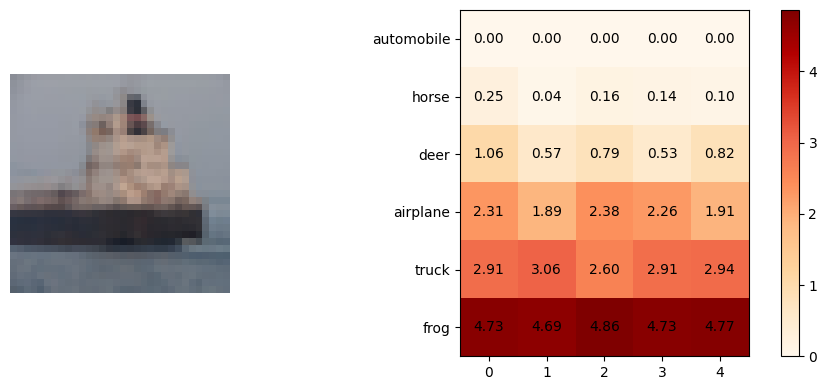

In [88]:
rejected_outputs("ship", index=9)

# Accepted unknowns

In [64]:
def accepted_unknown_outputs(class_name, index=0, top=6):
    save_path=os.path.join(FLAGS.save_path, 
                           FLAGS.prefix + class_name + "_" + str(index) + "_au_repr.pdf")
    
    inverse_dict = {v: k for k, v in classes_dict.items()}
    class_id = inverse_dict[class_name]
    known_classes = [classes_dict[i].rsplit(',')[0] for i in range(nb_classes)]
    
    fig = plt.figure(figsize=(14, 4))
    gs = GridSpec(1,3, figure=fig, width_ratios=[1, 3, 3])
    axs = [fig.add_subplot(gs[0, 0]), fig.add_subplot(gs[0, 1]), fig.add_subplot(gs[0, 2])]
    
    if class_id > 0:
        raise ValueError("Only works for unknowns")
    
    images = unknown_images[accepted_uk_preds]
    features = unknown_features[accepted_uk_preds]
    outputs = unknown_pred_raw[accepted_uk_preds]
    labels = unknown_labels[accepted_uk_preds]

    class_features = features[labels == class_id]
    class_outputs = outputs[labels == class_id]
    
    predicted_class = loss_helper.predicted_class([class_outputs[index]]).numpy()[0]
    print(f"Predicted class: {classes_dict[predicted_class]}")
    
    predicted_class_w_thr = roc_score_helper.predict_w_threshold(
        np.array([class_outputs[index]]), 
        rejection_threshold, 
        roc_score_helper.score_type).numpy()[0]
    predicted_name = classes_dict[predicted_class_w_thr] if predicted_class_w_thr >= 0 else "unknown"
    print(f"Predicted class with rejection threshold: {predicted_name}")
    
    # Plotting 
    axs[0].imshow(images[labels == class_id][index]/255)
    axs[0].set_title(f"True class: {class_name}\nPredicted class: {classes_dict[predicted_class]}", fontsize=16)
    axs[0].axis("off")
    
    if ANALYZE == "representation":
        new_shape = (-1, FLAGS.nb_features)
    else:
        new_shape = (nb_classes, 1) 
            
    reshaped = class_features[index].reshape(new_shape)
    
    # get top k
    top_k = np.argsort(np.sum(reshaped, axis=1))[-top:]
    reshaped = reshaped[top_k]
    
    im = axs[1].imshow(reshaped, cmap="OrRd")
    axs[1].set_title("Features", fontsize=16)
    # if FLAGS.loss == "dist":
    axs[1].set_yticks(range(top), np.array(known_classes)[top_k])
    for i in range(top):
        for j in range(new_shape[1]):
            axs[1].text(j, i, f"{reshaped[i, j]:.2f}", 
                     ha="center", va="center", color="k" )
    
    reshaped = mean_features[predicted_class].reshape(new_shape)[top_k]
    im = axs[2].imshow(reshaped, cmap="OrRd")
    axs[2].set_title("Mean representation of\npredicted class", fontsize=16)
    if FLAGS.loss == "dist":
        axs[2].set_yticks(range(top), known_classes[top_k])
    for i in range(top):
        for j in range(new_shape[1]):
            axs[2].text(j, i, f"{reshaped[i, j]:.2f}", 
                     ha="center", va="center", color="k" )
            
    fig.tight_layout()
    plt.colorbar(im, shrink=0.7, ax=axs[1:])
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    

In [65]:
classes_dict

{0: 'jinrikisha, ricksha, rickshaw',
 1: 'beach wagon, station wagon, wagon, estate car, beach waggon, station waggon, waggon',
 2: 'guinea pig, Cavia cobaya',
 3: 'pay-phone, pay-station',
 4: 'gondola',
 5: 'Christmas stocking',
 6: 'birdhouse',
 7: 'teddy, teddy bear',
 8: 'tractor',
 9: 'mashed potato',
 10: 'apron',
 11: 'brown bear, bruin, Ursus arctos',
 12: 'neck brace',
 13: 'chain',
 14: 'lesser panda, red panda, panda, bear cat, cat bear, Ailurus fulgens',
 15: 'binoculars, field glasses, opera glasses',
 16: 'trolleybus, trolley coach, trackless trolley',
 17: 'tabby, tabby cat',
 18: 'reel',
 19: 'barn',
 -1: 'Egyptian cat',
 -3: 'volleyball',
 -4: 'rocking chair, rocker',
 -5: 'lemon',
 -6: 'bullfrog, Rana catesbeiana',
 -7: 'basketball',
 -8: 'cliff, drop, drop-off',
 -9: 'espresso',
 -10: "plunger, plumber's helper",
 -11: 'parking meter',
 -12: 'German shepherd, German shepherd dog, German police dog, alsatian',
 -13: 'dining table, board',
 -14: 'monarch, monarch butt

Predicted class: brown bear, bruin, Ursus arctos
Predicted class with rejection threshold: brown bear, bruin, Ursus arctos


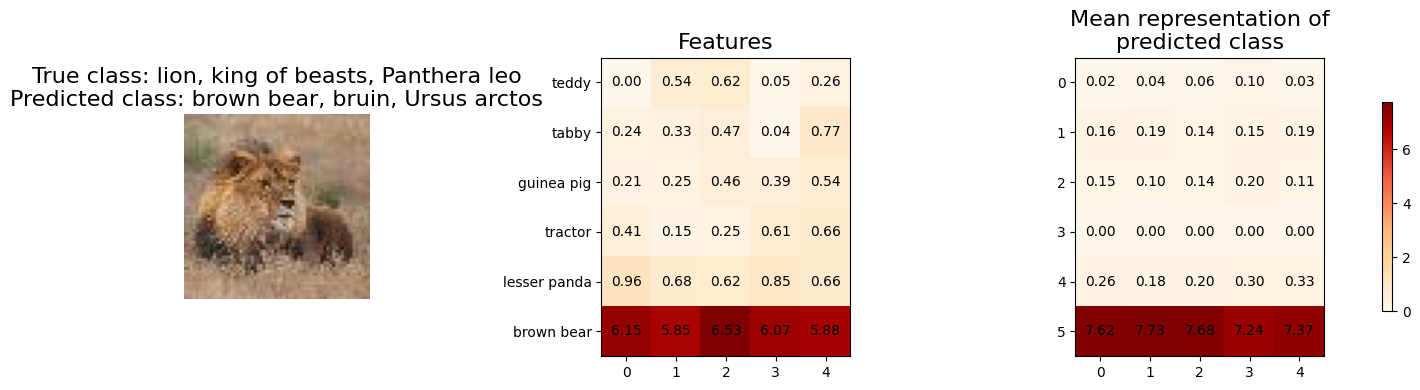

In [66]:
accepted_unknown_outputs("lion, king of beasts, Panthera leo", index=0)

# Mean representations of all classes

In [48]:
def test_mean_representations(top=6, save_name=None, threshold=None):
    test_features = known_features
    predicted_classes = known_pred_raw_label
    # sort correctly classified
    correctly_classified = known_labels == predicted_classes
    test_features_correct = test_features[correctly_classified]
    test_labels_correct = known_labels[correctly_classified]
    
    known_classes = [classes_dict[i].rsplit(',')[0] for i in range(nb_classes)]    

    fig, axs = plt.subplots(10, 2, figsize=(11, 40))
    axs = axs.flatten()
    
    vmin = np.min(mean_features)
    vmax = np.max(mean_features)
    
    for idx in range(nb_classes):
        
        if ANALYZE == "representation":
            new_shape = (-1, FLAGS.nb_features)
        else:
            new_shape = (nb_classes, 1)
        if FLAGS.loss == "crossentropy":
            new_shape = (16, 8)

        mean_repr = np.mean(test_features_correct[test_labels_correct == idx], axis=0)

        reshaped = mean_repr.reshape(new_shape)
        
        if threshold:
            reshaped = np.where(reshaped > threshold, reshaped, 0)
        
        
        # get top k
        if FLAGS.loss == "difair":
            top_k = np.argsort(np.sum(reshaped, axis=1))[-top:][::-1]
        else:
            top_k = np.s_[:]
        reshaped = reshaped[top_k]


        im = axs[idx].imshow(reshaped, cmap="OrRd", vmin=vmin, vmax=vmax)
        axs[idx].set_title("Mean representation of\n" + known_classes[idx], fontsize=16)
        if FLAGS.loss == "difair":
            axs[idx].set_yticks(range(top), np.array(known_classes)[top_k])
            for i in range(reshaped.shape[0]):
                for j in range(reshaped.shape[1]):
                    axs[idx].text(
                        j, i, f"{reshaped[i, j]:.2f}", ha="center", va="center", color="k"
                    )
        # add colorbar for each axis
        plt.colorbar(im, ax=axs[idx], shrink=0.7)
    for ax in range(nb_classes, 20):
        fig.delaxes(axs[ax])

    fig.tight_layout()
    # plt.colorbar(im, shrink=0.5, ax=axs)
    # plt.savefig(save_path, dpi=300, bbox_inches="tight")
    
    plt.show()

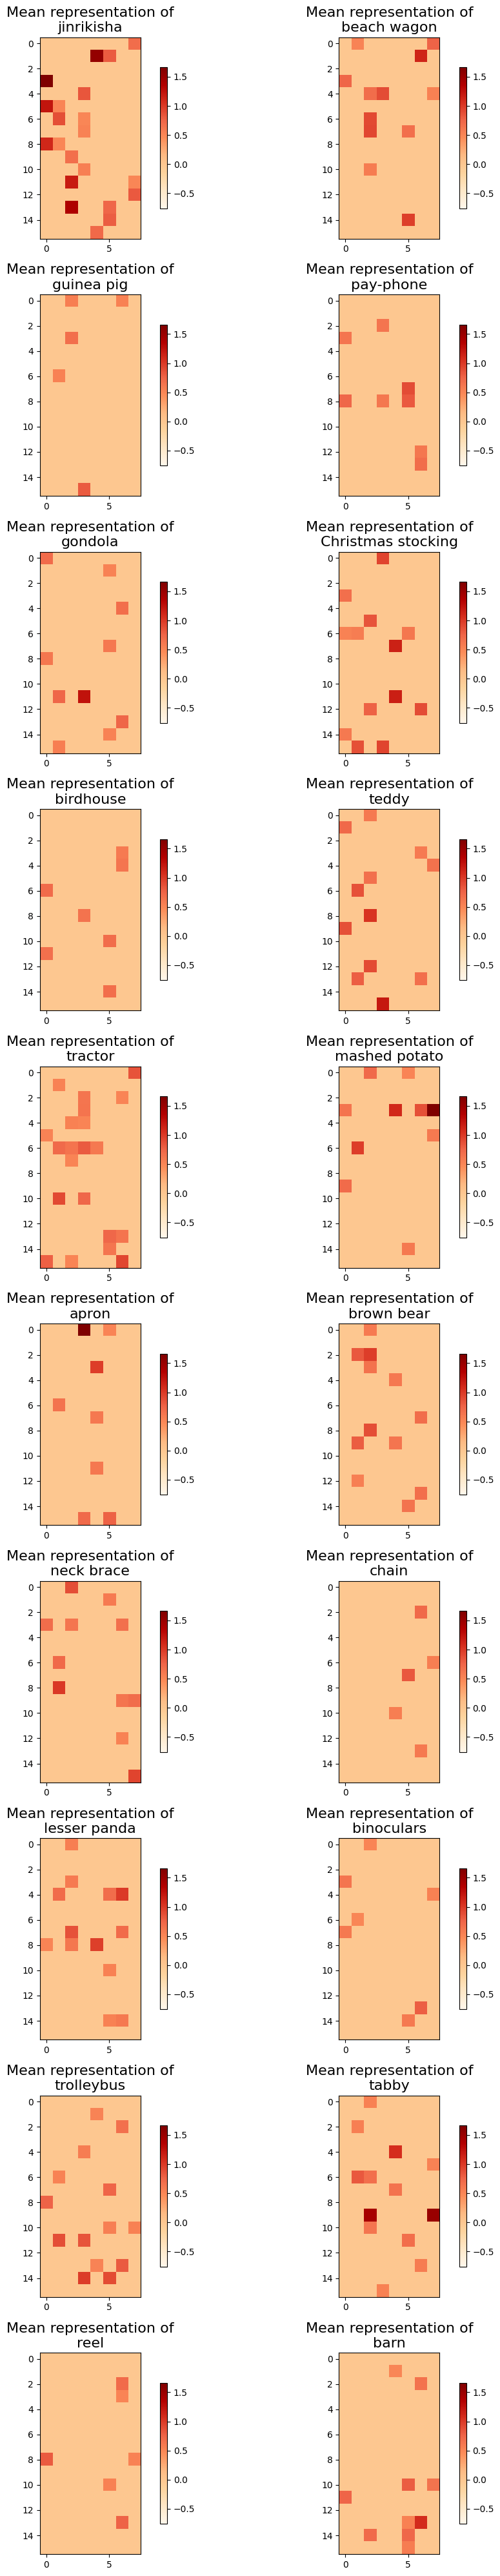

In [49]:
test_mean_representations(threshold=0.5)

In [32]:
def train_mean_representations(top=6, save_name=None):
    train_features = get_features.predict(train_images)
    predicted_classes = loss_helper.predicted_class(train_features)
    # sort correctly classified
    correctly_classified = train_labels == predicted_classes
    train_features_correct = train_features[correctly_classified]
    train_labels_correct = train_labels[correctly_classified]
    
    known_classes = [classes_dict[i].rsplit(',')[0] for i in range(nb_classes)]    

    fig, axs = plt.subplots(10, 2, figsize=(11, 40))
    axs = axs.flatten()
    
    vmin = np.min(mean_features)
    vmax = np.max(mean_features)
    
    for idx in range(nb_classes):
        
        if ANALYZE == "representation":
            new_shape = (-1, FLAGS.nb_features)
        else:
            new_shape = (nb_classes, 1)
            
        mean_repr = np.mean(train_features_correct[train_labels_correct == idx], axis=0)

        reshaped = mean_repr.reshape(new_shape)
        
        # get top k
        top_k = np.argsort(np.sum(reshaped, axis=1))[-top:][::-1]
        reshaped = reshaped[top_k]


        im = axs[idx].imshow(reshaped, cmap="OrRd", vmin=vmin, vmax=vmax)
        axs[idx].set_title("Mean representation of\n" + known_classes[idx], fontsize=16)
        if FLAGS.loss == "difair":
            axs[idx].set_yticks(range(top), np.array(known_classes)[top_k])
        for i in range(top):
            for j in range(new_shape[1]):
                axs[idx].text(
                    j, i, f"{reshaped[i, j]:.2f}", ha="center", va="center", color="k"
                )
    for ax in range(nb_classes, 20):
        fig.delaxes(axs[ax])

    fig.tight_layout()
    plt.colorbar(im, shrink=0.5, ax=axs)
    # plt.savefig(save_path, dpi=300, bbox_inches="tight")
    
    plt.show()

938/938 [==============================] - 3s 3ms/step


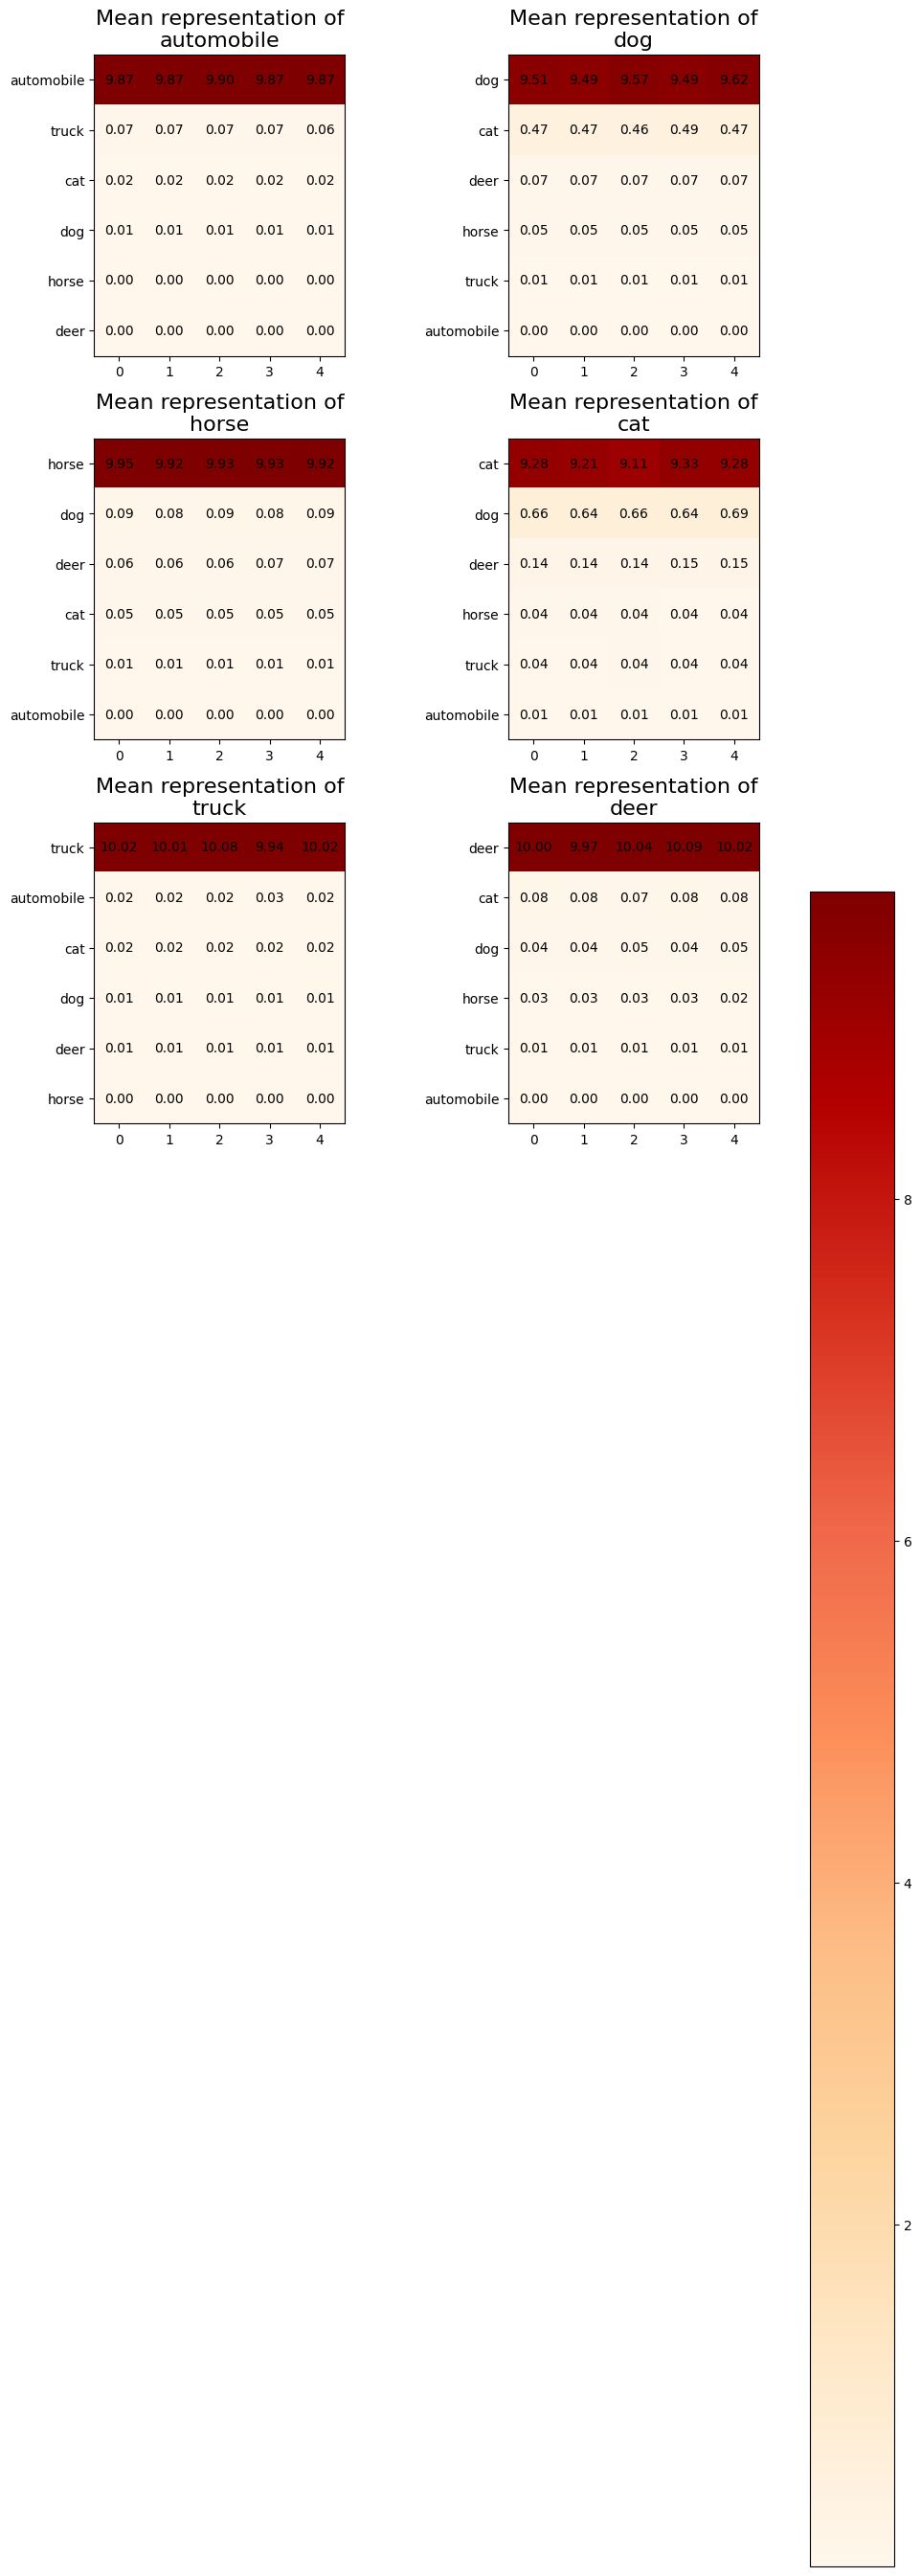

In [73]:
train_mean_representations()

In [32]:
def mean_representations(top=6, save_name=None):
    
    known_classes = [classes_dict[i].rsplit(',')[0] for i in range(nb_classes)]    

    fig, axs = plt.subplots(10, 2, figsize=(11, 40))
    axs = axs.flatten()
    
    vmin = np.min(mean_features)
    vmax = np.max(mean_features)
    
    for idx in range(nb_classes):
        
        if ANALYZE == "representation":
            new_shape = (-1, FLAGS.nb_features)
        else:
            new_shape = (nb_classes, 1)

        # AX[2] : Mean representation of predicted class
        reshaped = mean_features[idx].reshape(new_shape)
        
        # get top k
        top_k = np.argsort(np.sum(reshaped, axis=1))[-top:][::-1]
        reshaped = reshaped[top_k]


        im = axs[idx].imshow(reshaped, cmap="OrRd", vmin=vmin, vmax=vmax)
        axs[idx].set_title("Mean representation of\n" + known_classes[idx], fontsize=16)
        if FLAGS.loss == "difair":
            axs[idx].set_yticks(range(top), np.array(known_classes)[top_k])
        for i in range(top):
            for j in range(new_shape[1]):
                axs[idx].text(
                    j, i, f"{reshaped[i, j]:.2f}", ha="center", va="center", color="k"
                )

    fig.tight_layout()
    plt.colorbar(im, shrink=0.5, ax=axs)
    # plt.savefig(save_path, dpi=300, bbox_inches="tight")
    
    plt.show()

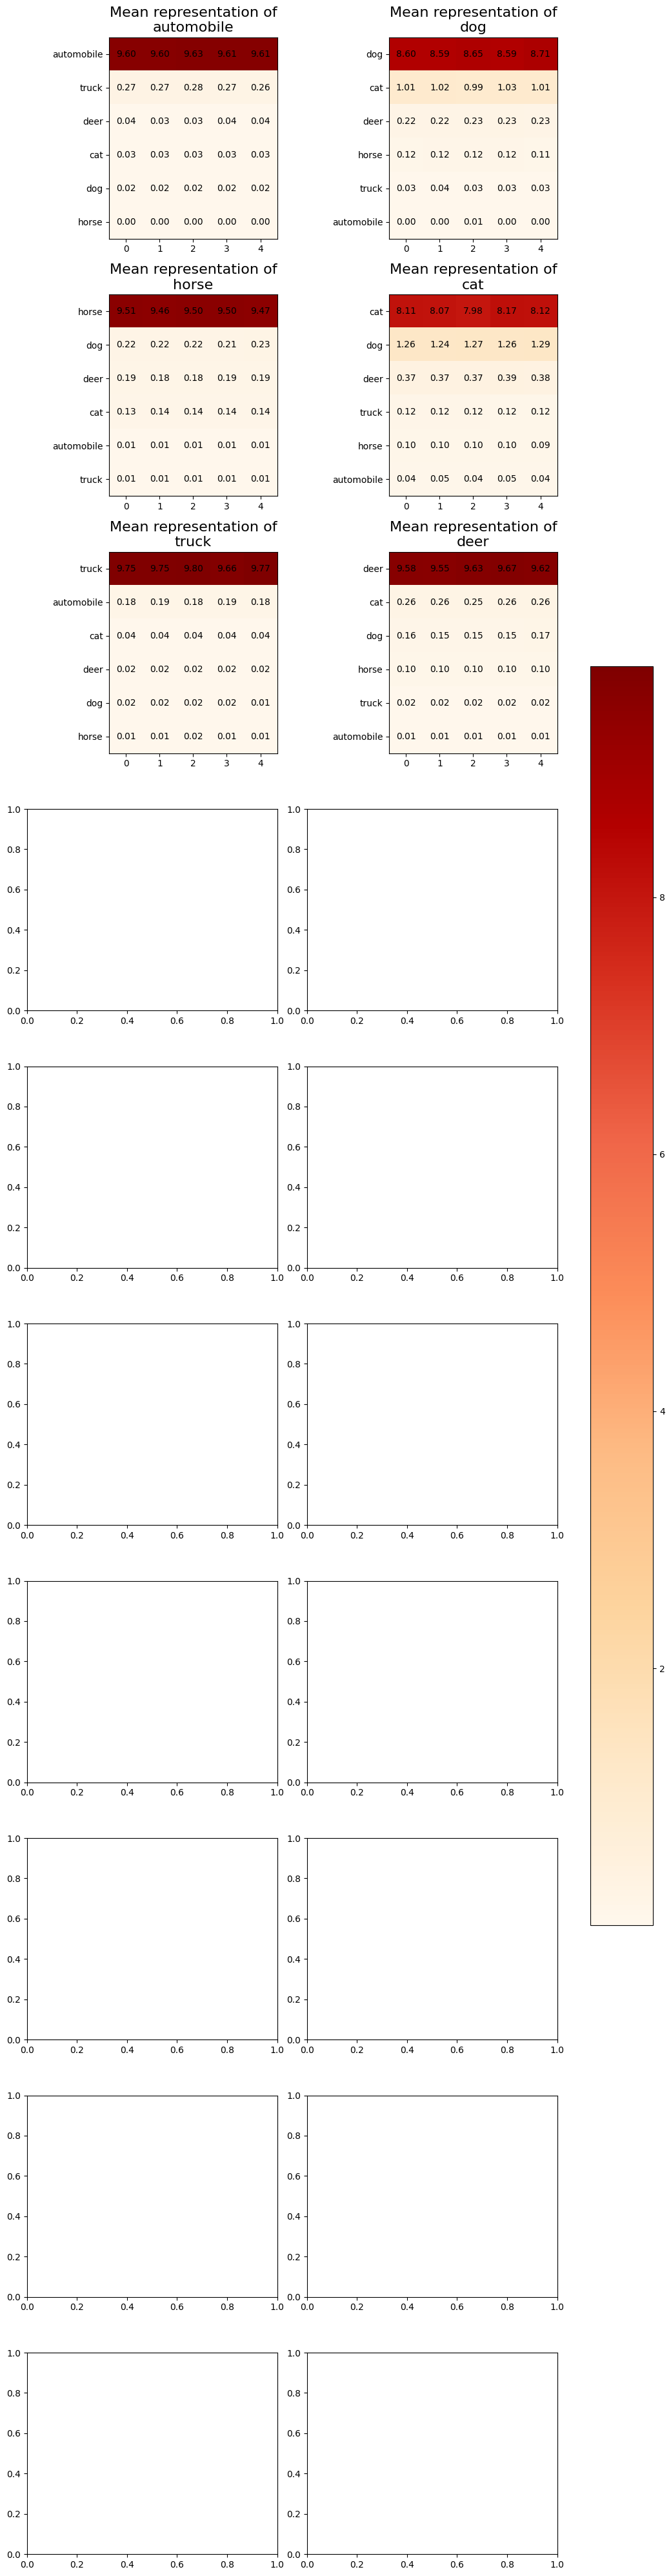

In [33]:
mean_representations()

# Visualize on class dimensions

(692, 30)
(692, 6, 5)
(692, 5)


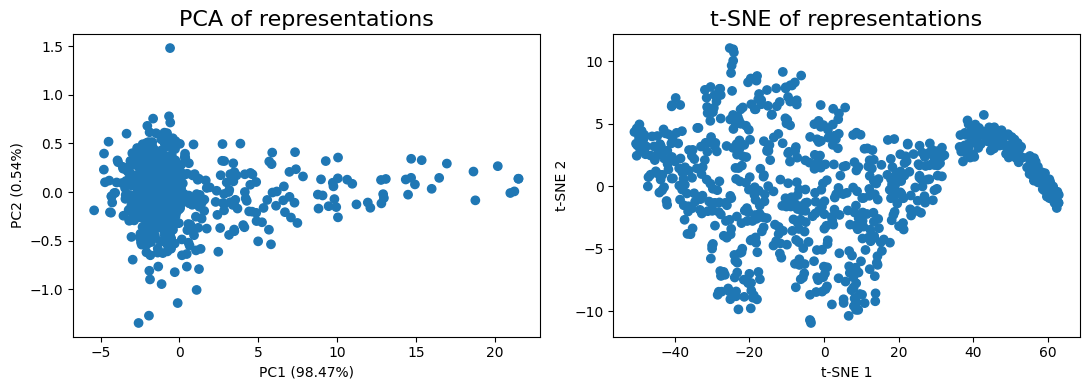

In [31]:
# PCA on representations
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
 
def plot_representation(class_name, save_name=None):
        
        inverse_dict = {v.rsplit(',')[0]: k for k, v in classes_dict.items()}
        class_id = inverse_dict[class_name]
        known_classes = [classes_dict[i].rsplit(',')[0] for i in range(nb_classes)]
        
        fig, axs = plt.subplots(1, 2, figsize=(11, 4))
        
        if class_id < 0:
            features = unknown_features
            outputs = unknown_pred_raw
            labels = unknown_labels
        else:
            features = known_features
            outputs = known_pred_raw
            labels = known_labels
            
        class_features = features[labels == class_id]
        print(class_features.shape)
        class_features = class_features.reshape(len(class_features), -1, FLAGS.nb_features)
        print(class_features.shape)
        class_features = class_features[:, class_id, :]
        print(class_features.shape)
        
        pca = PCA(n_components=2)
        pca.fit(class_features)
        pca_features = pca.transform(class_features)
        
        axs[0].scatter(pca_features[:, 0], pca_features[:, 1], c=labels[labels == class_id], cmap="tab10")
        axs[0].set_title("PCA of representations", fontsize=16)
        axs[0].set_xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.2f}%)")
        axs[0].set_ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.2f}%)")
        
        # tsne representation
        from sklearn.manifold import TSNE
        
        tsne = TSNE(n_components=2, random_state=42)
        tsne_features = tsne.fit_transform(class_features)
        
        axs[1].scatter(tsne_features[:, 0], tsne_features[:, 1], c=labels[labels == class_id], cmap="tab10")
        axs[1].set_title("t-SNE of representations", fontsize=16)
        axs[1].set_xlabel(f"t-SNE 1")
        axs[1].set_ylabel(f"t-SNE 2")
        
        fig.tight_layout()
        # plt.colorbar(im, shrink=0.7, ax=axs[1:])
        # plt.savefig(save_name, dpi=300, bbox_inches='tight')
        plt.show()
        
# plot_representation("trolleybus")
# plot_representation("tractor")
plot_representation("deer")

In [134]:
def return_features(class_name, only_class=None):
    inverse_dict = {v.rsplit(',')[0]: k for k, v in classes_dict.items()}
    class_id = inverse_dict[class_name]
    
    if class_id < 0:
        features = unknown_features
        outputs = unknown_pred_raw
        labels = unknown_labels
    else:
        features = known_features
        outputs = known_pred_raw
        labels = known_labels
        
    class_features = features[labels == class_id]
    if only_class:
        class_to_show = inverse_dict[only_class]
        class_features = class_features.reshape(len(class_features), -1, FLAGS.nb_features)
        class_features = class_features[:, class_to_show, :]
    
    return class_features

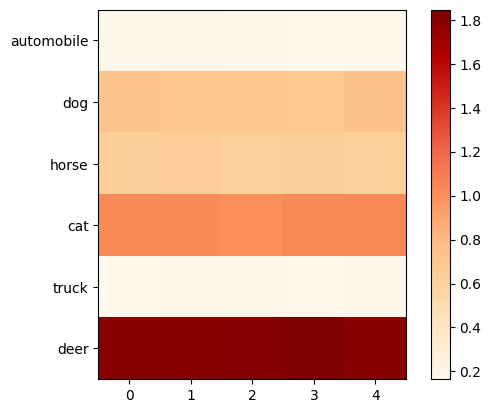

In [135]:
# ft_std = return_features("trolleybus").std(axis=0)
ft_std = return_features("deer").std(axis=0)


# plt.bar(range(len(ft_std)), ft_std)
ft_std = ft_std.reshape(-1, FLAGS.nb_features)

known_classes = [classes_dict[i].rsplit(",")[0] for i in range(nb_classes)]

plt.imshow(ft_std, cmap="OrRd")
plt.yticks(range(nb_classes), known_classes)
plt.colorbar()

In [156]:
def plot_features_distribution(class_name, only_class=None):
    features = return_features(class_name, only_class=only_class)
    mean = np.mean(features, axis=0)
    print(mean.round(1))

    plt.figure(figsize=(6, 3))
    plt.plot(range(features.shape[1]), features.T, color="k", alpha=0.1, marker="o")
    plt.plot(range(features.shape[1]), mean, color="r", marker="o")
    if features.shape[1] > FLAGS.nb_features:
        plt.xticks(range(0, features.shape[1], FLAGS.nb_features), 
                   range(0, features.shape[1], FLAGS.nb_features))
    else:
        plt.xticks(range(features.shape[1]), range(features.shape[1]))
    plt.show()
    
def plot_violin_distribution(class_name, only_class=None):
    features = return_features(class_name, only_class=only_class)
    
    plt.figure(figsize=(6, 3))
    plt.violinplot(features, showmeans=True, showmedians=True, showextrema=False)
    plt.show()

[0.  0.  0.  0.  0.  0.2 0.1 0.2 0.2 0.2 0.1 0.1 0.1 0.1 0.1 0.3 0.3 0.2
 0.3 0.3 0.  0.  0.  0.  0.  9.6 9.6 9.6 9.7 9.6]


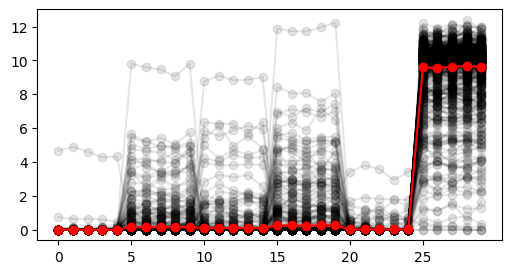

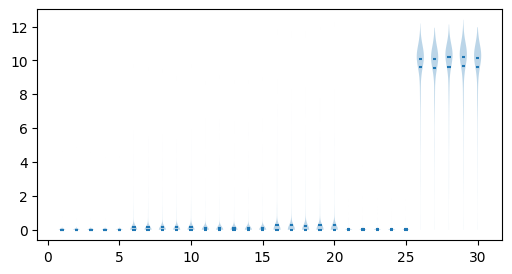

In [157]:
# plot_features_distribution("trolleybus")
plot_features_distribution("deer")
plot_violin_distribution("deer")

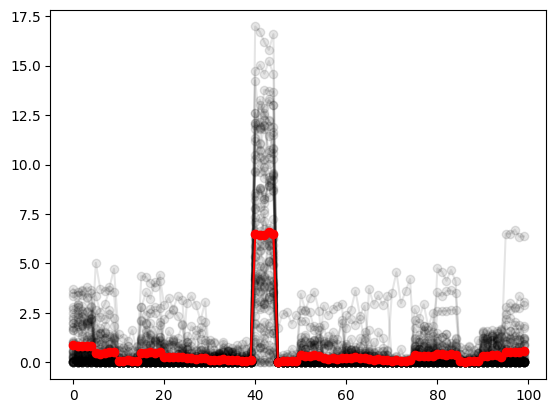

In [81]:
plot_features_distribution("tractor")

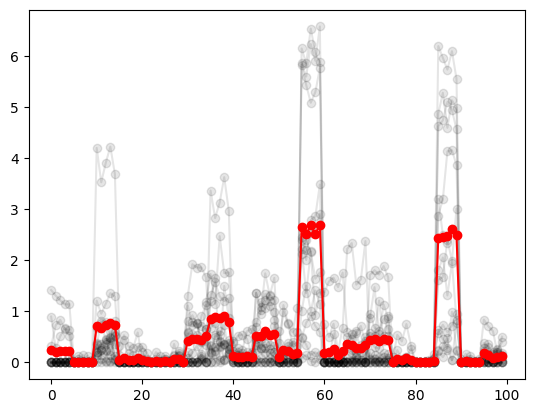

In [82]:
plot_features_distribution("lion")

# Explore all layers representations

In [ ]:
output_layers = [l.output for l in model.layers if "conv2d" in l.name]
full_extractor = tf.keras.models.Model(inputs=model.inputs, outputs=output_layers)

In [ ]:
def all_representations(class_name, index=0, top=6):
    
    save_path=os.path.join(FLAGS.save_path, 
                           FLAGS.prefix + class_name + "_" + str(index) + "_repr.pdf")
    
    inverse_dict = {v: k for k, v in classes_dict.items()}
    class_id = inverse_dict[class_name]
    known_classes = [classes_dict[i] for i in range(nb_classes)]
    
    
    fig = plt.figure(figsize=(9, 4))
    gs = GridSpec(1, 2, figure=fig, width_ratios=[1, 3])
    axs = [fig.add_subplot(gs[0, 0]), fig.add_subplot(gs[0, 1])]
    
    if class_id < 0:
        labels = unknown_labels
        image = unknown_images[labels == class_id][index]
        outputs = unknown_pred_raw
    else:
        labels = known_labels
        image = known_images[labels == class_id][index]
        outputs = known_pred_raw
        
    all_model_features = full_extractor.predict(image.reshape(1, FLAGS.image_size, FLAGS.image_size, 3))
    print(all_model_features[0].shape)
    
    class_outputs = outputs[labels == class_id][index]
    
    predicted_class = loss_helper.predicted_class([class_outputs]).numpy()[0]
    print(f"Predicted class: {classes_dict[predicted_class]}")
    
    features = all_model_features[-1].mean(axis=(1, 2))
    predicted_class = roc_score_helper.predict_w_threshold(
        np.array(features),
        rejection_threshold, 
        roc_score_helper.score_type).numpy()[0]
    predicted_name = classes_dict[predicted_class] if predicted_class >= 0 else "unknown"
    print(f"Predicted class with rejection threshold: {predicted_name}")
    
    
    axs[0].imshow(image/255)
    axs[0].axis("off")
    
    if ANALYZE == "representation":
        new_shape = (-1, FLAGS.nb_features)
    else:
        new_shape = (nb_classes, 1)    
    
    reshaped = features.reshape(new_shape)
    
    # get top k
    top_k = np.argsort(np.sum(reshaped, axis=1))[-top:]
    reshaped = reshaped[top_k]
    
    im = axs[1].imshow(reshaped, cmap="OrRd", vmax=10.5)
    if FLAGS.loss in ["dist", "new"]:
        axs[1].set_yticks(range(nb_classes), known_classes)
    for i in range(top):
        for j in range(new_shape[1]):
            axs[1].text(j, i, f"{reshaped[i, j]:.2f}", 
                     ha="center", va="center", color="k" )
            
    fig.tight_layout()
    plt.colorbar(im)
    # plt.savefig(save_path, dpi=300, bbox_inches='tight')
    
    for l_features, layer in zip(all_model_features, output_layers):
        avg_pooling = l_features.mean(axis=(1, 2)).squeeze()
        max_pooling = l_features.max(axis=(1, 2)).squeeze()
        
        plt.figure(figsize=(9, 4))
        plt.bar(range(len(avg_pooling)), avg_pooling)
        plt.title("Layer: " + layer.name)
        plt.show()
    

In [ ]:
classes_dict

{0: 'airplane',
 1: 'frog',
 2: 'deer',
 3: 'truck',
 4: 'automobile',
 5: 'horse',
 -3: 'bird',
 -4: 'cat',
 -6: 'dog',
 -9: 'ship'}

1/1 [==============================] - 0s 17ms/step
(1, 32, 32, 64)
Predicted class: deer
Predicted class with rejection threshold: unknown


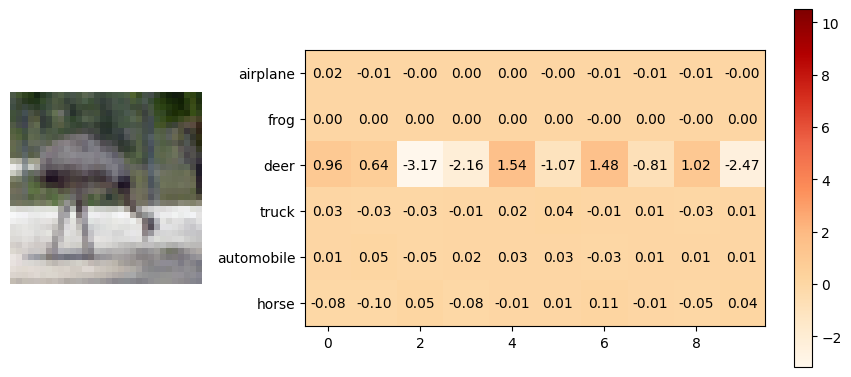

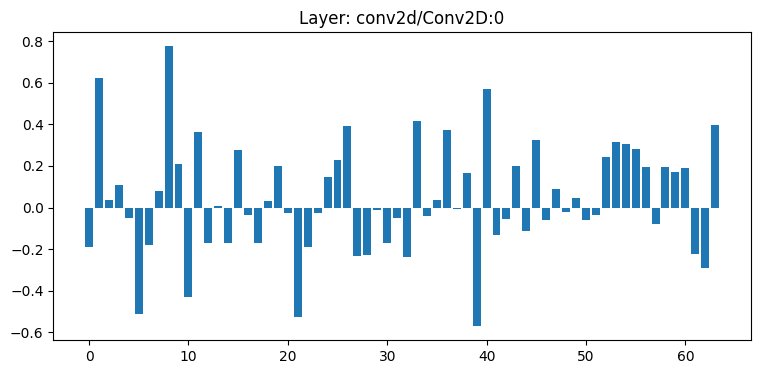

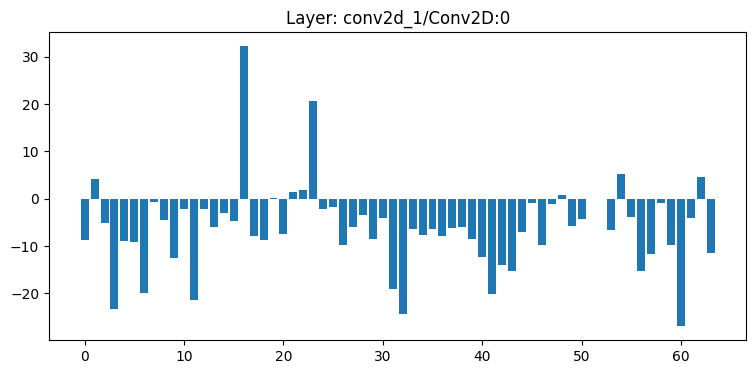

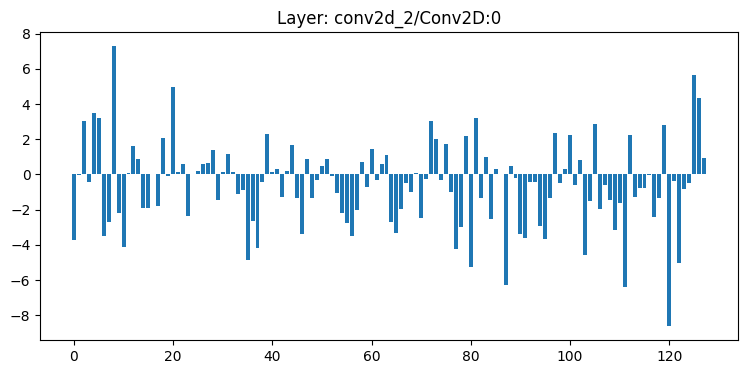

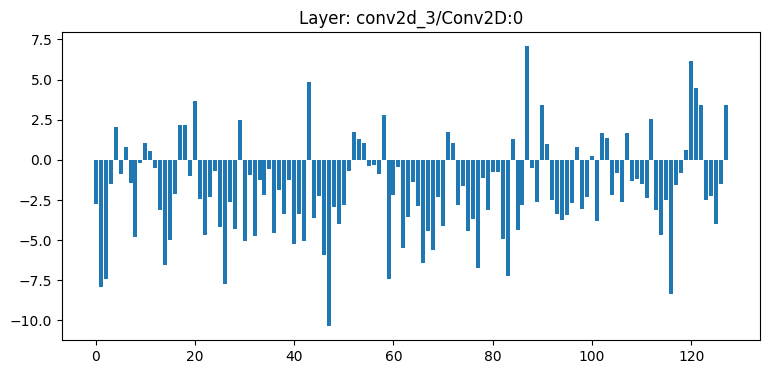

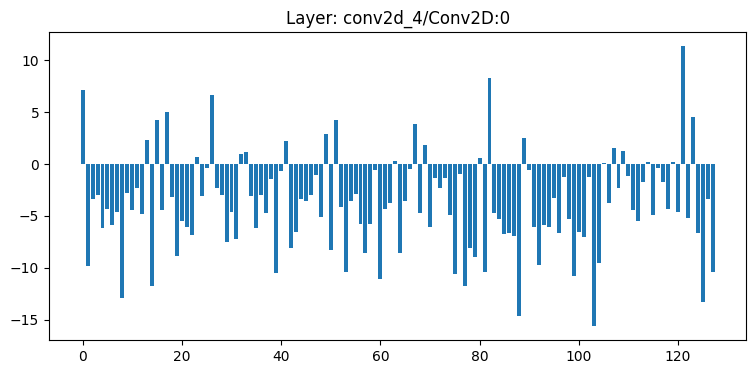

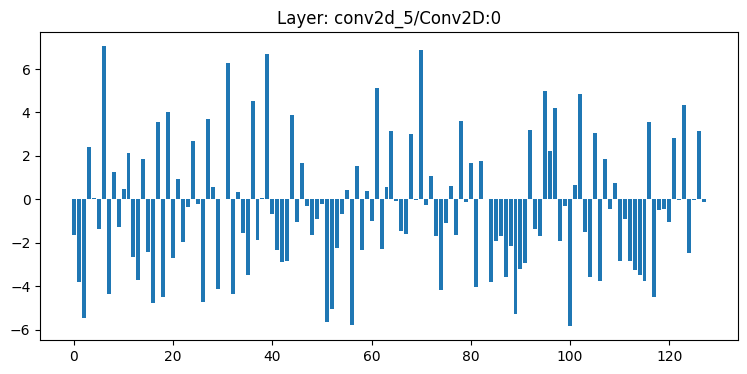

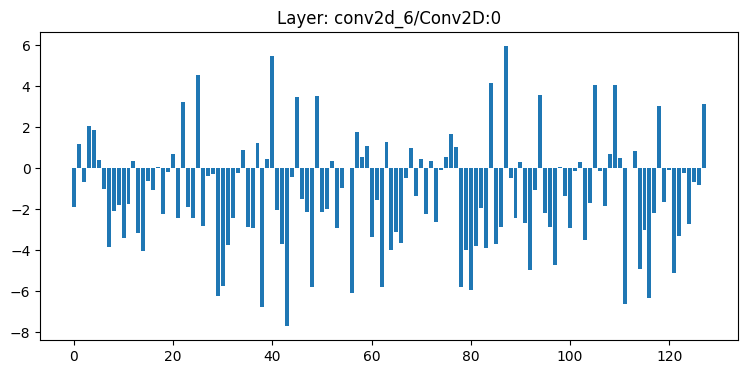

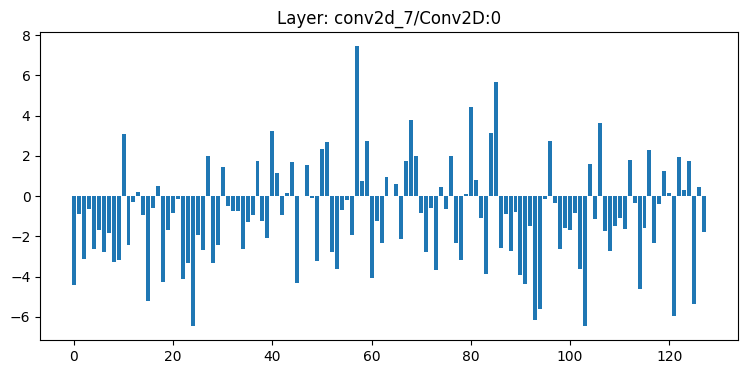

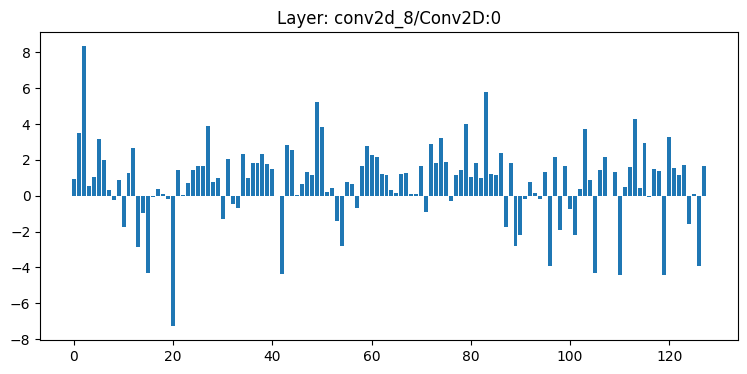

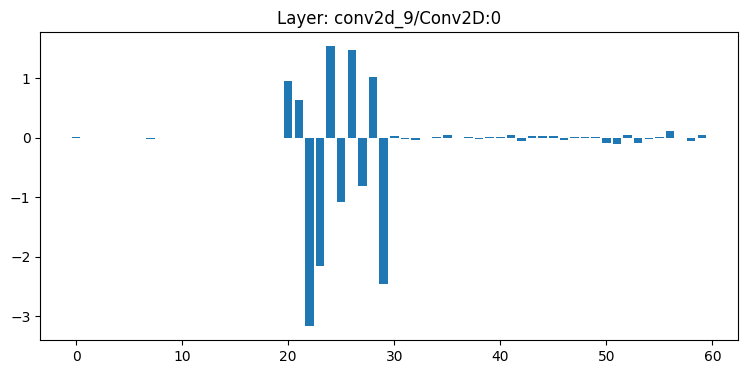

In [ ]:
all_representations("bird", index=0)

# Features behavior

In [76]:
# known_images, known_labels = zip(*datasets["ds_test_known"].unbatch())
# known_images = np.array(known_images)
# known_labels = np.array(known_labels)
# label_names = [classes_dict[i] for i in range(nb_classes)]

# known_features = get_features.predict(known_images)
# known_pred_raw = model.predict(known_images)
# known_pred_raw_label = loss_helper.predicted_class(known_pred_raw)


# unknown_images, raw_unknown_labels = zip(*datasets["ds_test_unknown"].unbatch())
# unknown_images = np.array(unknown_images)
# raw_unknown_labels = np.array(raw_unknown_labels)

# unknown_features = get_features.predict(unknown_images)
# unknown_labels = np.array([-label-1 for label in raw_unknown_labels]) # negated-1 labels for unknowns
# unknown_pred_raw = model.predict(datasets["ds_test_unknown"])
# unknown_pred_raw_label = loss_helper.predicted_class(unknown_pred_raw)

In [78]:
def plot_feature_distribution(class_features, feature_index):
    if ANALYZE == "representation":
        new_shape = (-1, nb_classes, FLAGS.nb_features)
    else:
        new_shape = (-1, nb_classes, 1) 
    
    reshaped_known_features = known_features.reshape(new_shape)
    reshaped_unknown_features = unknown_features.reshape(new_shape)
    
    all_features = np.concatenate([reshaped_known_features, reshaped_unknown_features], axis=0)
    all_labels = np.concatenate([known_labels, unknown_labels], axis=0)

    inverse_dict = {v: k for k, v in classes_dict.items()}
    class_id = inverse_dict[class_features]
    
    # get names and ids
    tuples = classes_dict.items()
    class_names = [v for k, v in tuples]
    class_ids = [k for k, v in tuples]

    studied_feature = all_features[:, class_id, feature_index]
    studied_feature.shape
    
    data = []
    class_names = []
    for id, class_name in classes_dict.items():
        class_names.append(class_name)
        data.append(studied_feature[all_labels == id])

    fig, ax = plt.subplots(figsize=(8, 3))
    ax.violinplot(data, showmeans=False, showmedians=True)
    ax.set_xticks(range(1, len(class_names)+1))
    ax.set_xticklabels(class_names, rotation=45)
    ax.set_ylabel('Feature Activation')
    ax.set_title('Activations of feature ' + str(feature_index) + ' of the ' + class_features + ' class')
    plt.show()
    
    
    

None


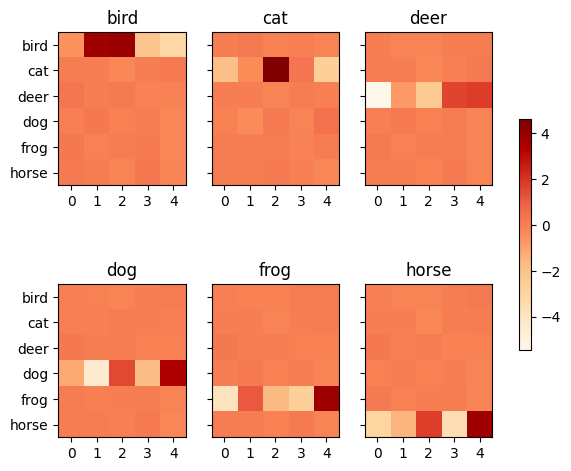

In [79]:
from visualization.features import plot_mean_features

plot_mean_features(mean_features=mean_features, nb_features=FLAGS.nb_features, class_names=label_names, identified_features=True)
plt.show()

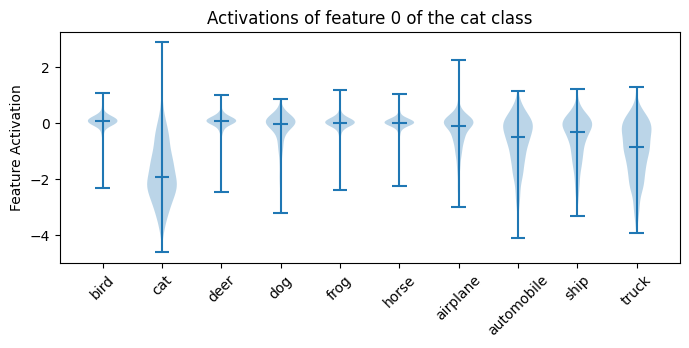

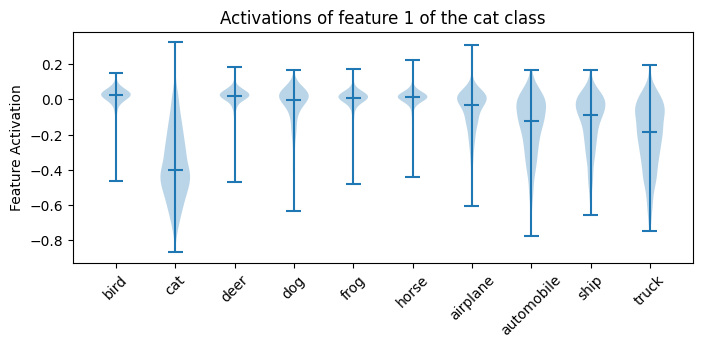

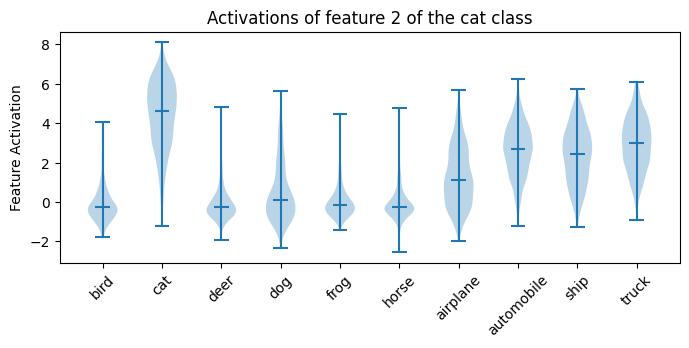

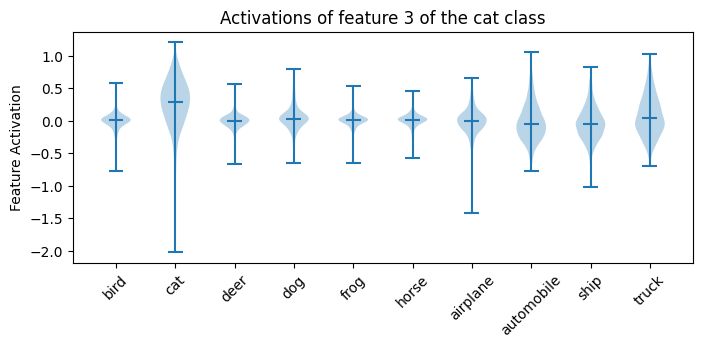

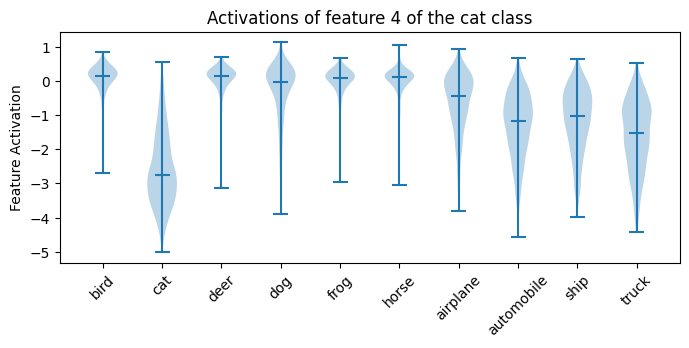

In [80]:
for i in range(FLAGS.nb_features):
    plot_feature_distribution("cat", i)

In [ ]:
classes_dict

{0: 'bird',
 1: 'cat',
 2: 'deer',
 3: 'dog',
 4: 'frog',
 5: 'horse',
 -1: 'airplane',
 -2: 'automobile',
 -9: 'ship',
 -10: 'truck'}

# Blind test known/unknown

In [44]:
def plot_feature_distribution_blind():
    class_features = classes_dict[np.random.choice(nb_classes)]
    
    if ANALYZE == "representation":
        new_shape = (-1, nb_classes, FLAGS.nb_features)
    else:
        new_shape = (-1, nb_classes, 1) 
    
    reshaped_known_features = known_features.reshape(new_shape)
    reshaped_unknown_features = unknown_features.reshape(new_shape)
    
    all_features = np.concatenate([reshaped_known_features, reshaped_unknown_features], axis=0)
    all_labels = np.concatenate([known_labels, unknown_labels], axis=0)

    inverse_dict = {v: k for k, v in classes_dict.items()}
    class_id = inverse_dict[class_features]
    
    # get names and ids
    tuples = classes_dict.items()
    class_names = [v for k, v in tuples]
    class_ids = [k for k, v in tuples]

    shuffled_index = list(classes_dict.keys())
    np.random.shuffle(shuffled_index)
    shuffled_classes = [(k, classes_dict[k]) for k in shuffled_index]
    
    for feature_index in range(FLAGS.nb_features):
        studied_feature = all_features[:, class_id, feature_index]
        studied_feature.shape
        
        data = []
        class_names = []
        for id, class_name in shuffled_classes:
            class_names.append(class_name)
            data.append(studied_feature[all_labels == id])

        fig, ax = plt.subplots(figsize=(8, 3))
        ax.violinplot(data, showmeans=False, showmedians=True)
        ax.hlines(0, 0, len(class_names)+1, color="k", linestyle="--", alpha=0.5)
        ax.set_xticks(range(1, len(class_names)+1))
        # ax.set_xticklabels(class_names, rotation=45)
        ax.set_ylabel('Feature Activation')
        ax.set_title('Activations of feature ' + str(feature_index) + ' of some class')
        plt.show()
    
    print("*"*50)
    input("Press enter to see the results...")
    
    for feature_index in range(FLAGS.nb_features):
        studied_feature = all_features[:, class_id, feature_index]
        studied_feature.shape
        
        data = []
        class_names = []
        for id, class_name in shuffled_classes:
            class_names.append(class_name)
            data.append(studied_feature[all_labels == id])

        fig, ax = plt.subplots(figsize=(8, 3))
        ax.violinplot(data, showmeans=False, showmedians=True)
        ax.set_xticks(range(1, len(class_names)+1))
        ax.set_xticklabels(class_names, rotation=45)
        for tick in ax.get_xticklabels():
            if inverse_dict[tick.get_text()] >= 0:
                tick.set_color("green")
            else:
                tick.set_color("red")
        ax.set_ylabel('Feature Activation')
        ax.set_title('Activations of feature ' + str(feature_index) + ' of the ' + class_features + ' class')
        plt.show()
    
    

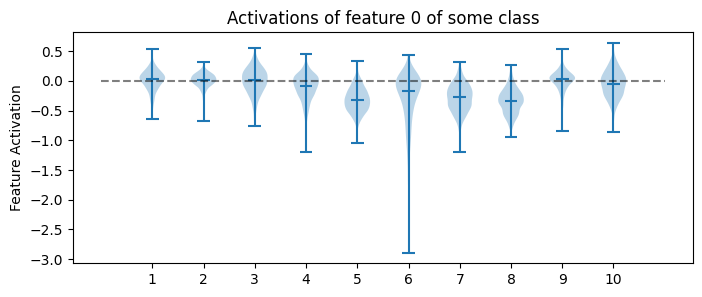

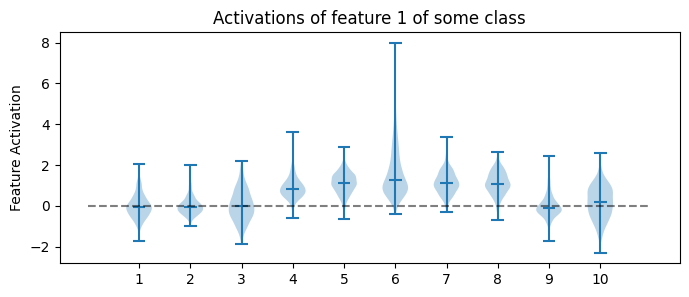

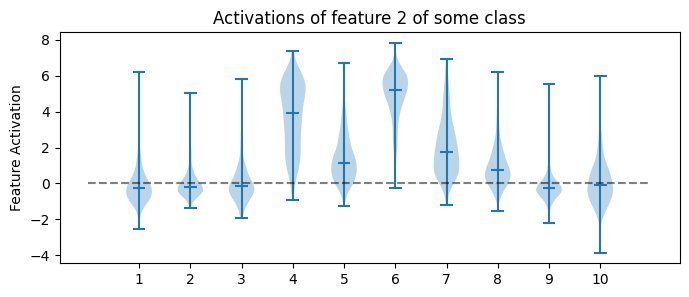

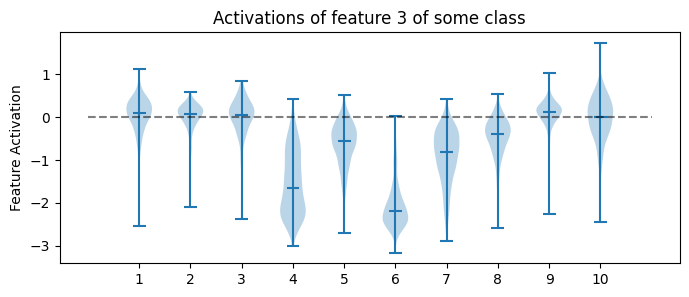

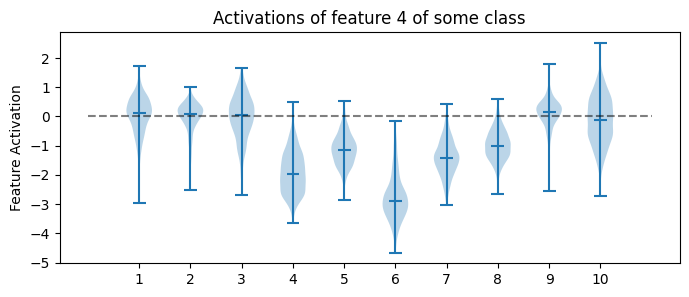

**************************************************


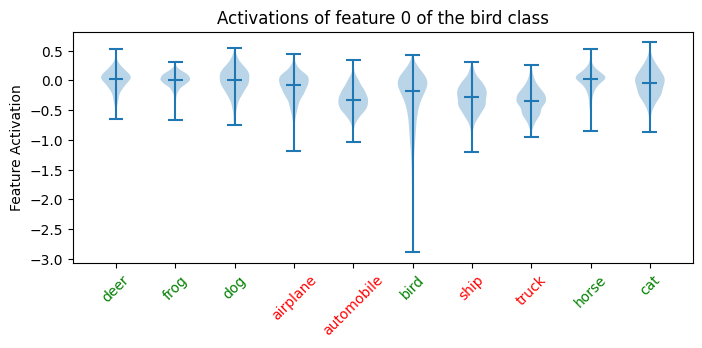

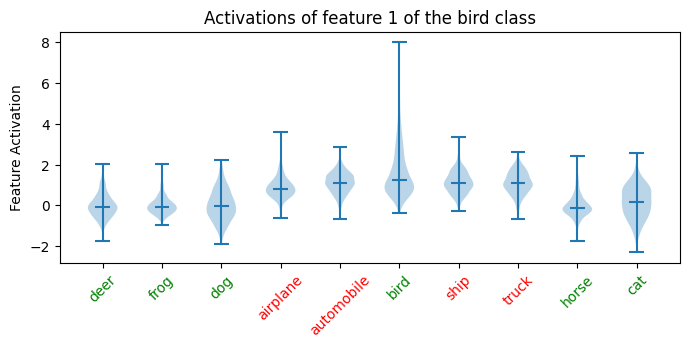

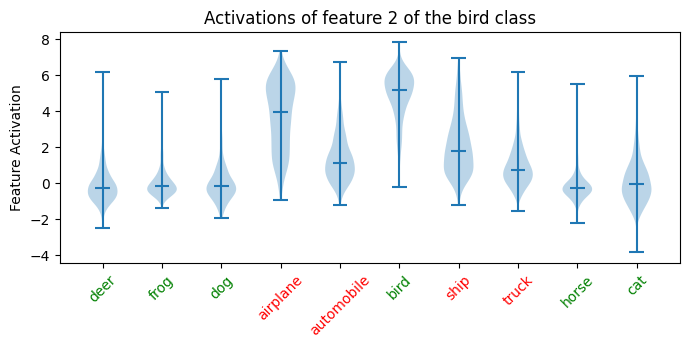

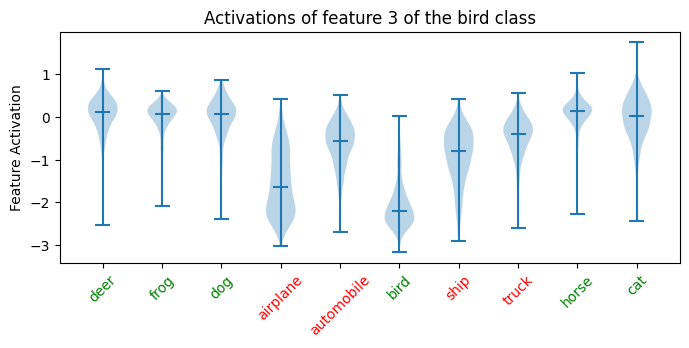

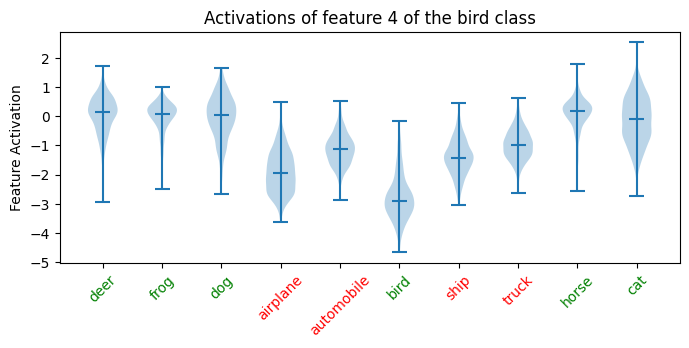

In [45]:
plot_feature_distribution_blind()

# Adding fully connected layer

In [35]:
# reload dataset with data augmentation

aug_datasets, nb_classes, nb_batches, nb_channels, norm_layer, classes_dict = load_dataset(
    FLAGS,
    shuffle=False,
    parallel_strategy=None,
    data_augmentation=True
)

Dataset: cifar10
Known classes: [2, 3, 4, 5, 6, 7]
Unknown classes: [0, 1, 8, 9]
nb_train_examples: 24000
mean: [0.4880581, 0.4659989, 0.39940587]
variance: [0.05665088, 0.05391809, 0.0582388]
Using rand augment


In [59]:
inputs = model.inputs

representation = model(inputs, training=False)

out = tf.keras.layers.Dense(128, activation='relu')(representation)
# out = representation

outputs = tf.keras.layers.Dense(nb_classes, activation=None)(out)

new_model = tf.keras.models.Model(inputs=inputs, outputs=outputs)

In [60]:
new_model.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 model (Functional)          (None, 30)                1035712   
                                                                 
 dense_5 (Dense)             (None, 128)               3968      
                                                                 
 dense_6 (Dense)             (None, 6)                 774       
                                                                 
Total params: 1,040,454
Trainable params: 1,038,406
Non-trainable params: 2,048
_________________________________________________________________


In [61]:
new_model.compile(
    optimizer=tf.keras.optimizers.SGD(learning_rate=1e-2),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"]
)

new_model.fit(datasets["ds_train_known"], epochs=10)

Epoch 1/10
188/188 [==============================] - 9s 39ms/step - loss: 0.3720 - accuracy: 0.8867
Epoch 2/10
188/188 [==============================] - 8s 43ms/step - loss: 0.2486 - accuracy: 0.9125
Epoch 3/10
188/188 [==============================] - 8s 43ms/step - loss: 0.2378 - accuracy: 0.9137
Epoch 4/10
188/188 [==============================] - 8s 43ms/step - loss: 0.2329 - accuracy: 0.9137
Epoch 5/10
188/188 [==============================] - 8s 43ms/step - loss: 0.2292 - accuracy: 0.9151
Epoch 6/10
188/188 [==============================] - 8s 43ms/step - loss: 0.2252 - accuracy: 0.9172
Epoch 7/10
188/188 [==============================] - 8s 43ms/step - loss: 0.2244 - accuracy: 0.9165
Epoch 8/10
188/188 [==============================] - 8s 43ms/step - loss: 0.2246 - accuracy: 0.9154
Epoch 9/10
188/188 [==============================] - 8s 43ms/step - loss: 0.2175 - accuracy: 0.9183
Epoch 10/10
188/188 [==============================] - 8s 43ms/step - loss: 0.2179 - accura

In [62]:
new_model.compile(
    optimizer=tf.keras.optimizers.SGD(learning_rate=1e-3),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"]
)

new_model.fit(datasets["ds_train_known"], epochs=10)

Epoch 1/10
188/188 [==============================] - 10s 41ms/step - loss: 0.2202 - accuracy: 0.9162
Epoch 2/10
188/188 [==============================] - 8s 43ms/step - loss: 0.2199 - accuracy: 0.9168
Epoch 3/10
188/188 [==============================] - 8s 43ms/step - loss: 0.2167 - accuracy: 0.9180
Epoch 4/10
188/188 [==============================] - 8s 43ms/step - loss: 0.2133 - accuracy: 0.9198
Epoch 5/10
188/188 [==============================] - 8s 43ms/step - loss: 0.2175 - accuracy: 0.9180
Epoch 6/10
188/188 [==============================] - 8s 43ms/step - loss: 0.2173 - accuracy: 0.9182
Epoch 7/10
188/188 [==============================] - 8s 43ms/step - loss: 0.2159 - accuracy: 0.9180
Epoch 8/10
188/188 [==============================] - 8s 43ms/step - loss: 0.2173 - accuracy: 0.9190
Epoch 9/10
188/188 [==============================] - 8s 43ms/step - loss: 0.2155 - accuracy: 0.9196
Epoch 10/10
188/188 [==============================] - 8s 43ms/step - loss: 0.2170 - accur

In [63]:
new_model.evaluate(datasets["ds_test_known"])

32/32 [==============================] - 1s 14ms/step - loss: 0.3260 - accuracy: 0.9075


[0.32597601413726807, 0.9075000286102295]

In [64]:
from helpers.crossentropy import CrossEntropyHelper

eval = {}
eval["pred_known"] = new_model.predict(datasets["ds_test_known"])
eval["pred_unknown"] = new_model.predict(datasets["ds_test_unknown"])

eval_loss_helper = CrossEntropyHelper(osr_score="max", use_softmax=True)
eval_loss_helper.auroc(eval["pred_known"], eval["pred_unknown"])

32/32 [==============================] - 0s 12ms/step


0.8432442187499999